In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = True
enable_orig = False
enable_aug = False
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 2048
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-True-enable_orig-False-enable_aug-False-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-2048-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

5000
5000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


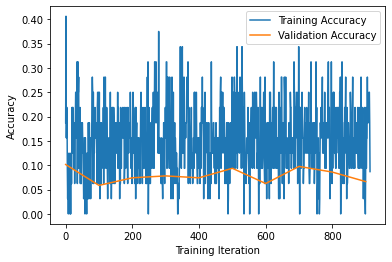

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.198 Validation Loss: 2.193 Accuracy: 0.000 Validation Accuracy: 0.119:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.197 Validation Loss: 2.193 Accuracy: 0.160 Validation Accuracy: 0.119:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.193 Validation Loss: 2.193 Accuracy: 0.279 Validation Accuracy: 0.119:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.189 Validation Loss: 2.193 Accuracy: 0.336 Validation Accuracy: 0.119:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.189 Validation Loss: 2.193 Accuracy: 0.336 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 4 Loss: 2.185 Validation Loss: 2.193 Accuracy: 0.373 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 5 Loss: 2.181 Validation Loss: 2.193 Accuracy: 0.398 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 6 Loss: 2.176 Validation Loss: 2.193 Accuracy: 0.410 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 7 Loss: 2.173 Validation Loss: 2.193 Accuracy: 0.427 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 8 Loss: 2.171 Validation Loss: 2.193 Accuracy: 0.429 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 9 Loss: 2.167 Validation Loss: 2.193 Accuracy: 0.434 Validation Accuracy: 0.119:  10%|█         | 4/40 [00:00<00:00, 37.24it/s]

Epoch: 0 Iteration: 9 Loss: 2.167 Validation Loss: 2.193 Accuracy: 0.434 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 10 Loss: 2.163 Validation Loss: 2.193 Accuracy: 0.479 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 11 Loss: 2.159 Validation Loss: 2.193 Accuracy: 0.490 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 12 Loss: 2.155 Validation Loss: 2.193 Accuracy: 0.495 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 13 Loss: 2.151 Validation Loss: 2.193 Accuracy: 0.495 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 14 Loss: 2.147 Validation Loss: 2.193 Accuracy: 0.491 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 15 Loss: 2.142 Validation Loss: 2.193 Accuracy: 0.492 Validation Accuracy: 0.119:  25%|██▌       | 10/40 [00:00<00:00, 48.19it/s]

Epoch: 0 Iteration: 15 Loss: 2.142 Validation Loss: 2.193 Accuracy: 0.492 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 16 Loss: 2.138 Validation Loss: 2.193 Accuracy: 0.491 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 17 Loss: 2.134 Validation Loss: 2.193 Accuracy: 0.484 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 18 Loss: 2.131 Validation Loss: 2.193 Accuracy: 0.498 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 19 Loss: 2.128 Validation Loss: 2.193 Accuracy: 0.495 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 20 Loss: 2.122 Validation Loss: 2.193 Accuracy: 0.498 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 21 Loss: 2.115 Validation Loss: 2.193 Accuracy: 0.496 Validation Accuracy: 0.119:  40%|████      | 16/40 [00:00<00:00, 51.88it/s]

Epoch: 0 Iteration: 21 Loss: 2.115 Validation Loss: 2.193 Accuracy: 0.496 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 22 Loss: 2.108 Validation Loss: 2.193 Accuracy: 0.495 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 23 Loss: 2.101 Validation Loss: 2.193 Accuracy: 0.489 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 24 Loss: 2.094 Validation Loss: 2.193 Accuracy: 0.483 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 25 Loss: 2.089 Validation Loss: 2.193 Accuracy: 0.473 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 26 Loss: 2.081 Validation Loss: 2.193 Accuracy: 0.484 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 27 Loss: 2.073 Validation Loss: 2.193 Accuracy: 0.479 Validation Accuracy: 0.119:  55%|█████▌    | 22/40 [00:00<00:00, 54.29it/s]

Epoch: 0 Iteration: 27 Loss: 2.073 Validation Loss: 2.193 Accuracy: 0.479 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 28 Loss: 2.064 Validation Loss: 2.193 Accuracy: 0.473 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 29 Loss: 2.054 Validation Loss: 2.193 Accuracy: 0.487 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 30 Loss: 2.045 Validation Loss: 2.193 Accuracy: 0.489 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 31 Loss: 2.038 Validation Loss: 2.193 Accuracy: 0.495 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 32 Loss: 2.029 Validation Loss: 2.193 Accuracy: 0.495 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 33 Loss: 2.019 Validation Loss: 2.193 Accuracy: 0.506 Validation Accuracy: 0.119:  70%|███████   | 28/40 [00:00<00:00, 55.60it/s]

Epoch: 0 Iteration: 33 Loss: 2.019 Validation Loss: 2.193 Accuracy: 0.506 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 34 Loss: 2.010 Validation Loss: 2.193 Accuracy: 0.517 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 35 Loss: 2.002 Validation Loss: 2.193 Accuracy: 0.523 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 36 Loss: 1.992 Validation Loss: 2.193 Accuracy: 0.519 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 37 Loss: 1.981 Validation Loss: 2.193 Accuracy: 0.534 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 38 Loss: 1.970 Validation Loss: 2.193 Accuracy: 0.539 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 39 Loss: 1.953 Validation Loss: 2.193 Accuracy: 0.530 Validation Accuracy: 0.119:  85%|████████▌ | 34/40 [00:00<00:00, 56.39it/s]

Epoch: 0 Iteration: 39 Loss: 1.953 Validation Loss: 2.193 Accuracy: 0.530 Validation Accuracy: 0.119: 100%|██████████| 40/40 [00:00<00:00, 57.46it/s]

Epoch: 0 Iteration: 39 Loss: 1.953 Validation Loss: 2.193 Accuracy: 0.530 Validation Accuracy: 0.119: 100%|██████████| 40/40 [00:00<00:00, 54.60it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 1.941 Validation Loss: 2.342 Accuracy: 0.525 Validation Accuracy: 0.127:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 1.929 Validation Loss: 2.342 Accuracy: 0.523 Validation Accuracy: 0.127:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 1.918 Validation Loss: 2.342 Accuracy: 0.526 Validation Accuracy: 0.127:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 1.903 Validation Loss: 2.342 Accuracy: 0.527 Validation Accuracy: 0.127:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 1.891 Validation Loss: 2.342 Accuracy: 0.522 Validation Accuracy: 0.127:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 1.891 Validation Loss: 2.342 Accuracy: 0.522 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 5 Loss: 1.875 Validation Loss: 2.342 Accuracy: 0.522 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 6 Loss: 1.864 Validation Loss: 2.342 Accuracy: 0.515 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 7 Loss: 1.850 Validation Loss: 2.342 Accuracy: 0.508 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 8 Loss: 1.837 Validation Loss: 2.342 Accuracy: 0.502 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 9 Loss: 1.823 Validation Loss: 2.342 Accuracy: 0.502 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 10 Loss: 1.810 Validation Loss: 2.342 Accuracy: 0.514 Validation Accuracy: 0.127:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 1 Iteration: 10 Loss: 1.810 Validation Loss: 2.342 Accuracy: 0.514 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 11 Loss: 1.793 Validation Loss: 2.342 Accuracy: 0.523 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 12 Loss: 1.775 Validation Loss: 2.342 Accuracy: 0.513 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 13 Loss: 1.760 Validation Loss: 2.342 Accuracy: 0.507 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 14 Loss: 1.741 Validation Loss: 2.342 Accuracy: 0.510 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 15 Loss: 1.723 Validation Loss: 2.342 Accuracy: 0.509 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 16 Loss: 1.702 Validation Loss: 2.342 Accuracy: 0.521 Validation Accuracy: 0.127:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 1 Iteration: 16 Loss: 1.702 Validation Loss: 2.342 Accuracy: 0.521 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 17 Loss: 1.682 Validation Loss: 2.342 Accuracy: 0.523 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 18 Loss: 1.663 Validation Loss: 2.342 Accuracy: 0.523 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 19 Loss: 1.649 Validation Loss: 2.342 Accuracy: 0.526 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 20 Loss: 1.630 Validation Loss: 2.342 Accuracy: 0.514 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 21 Loss: 1.606 Validation Loss: 2.342 Accuracy: 0.509 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 22 Loss: 1.583 Validation Loss: 2.342 Accuracy: 0.511 Validation Accuracy: 0.127:  42%|████▎     | 17/40 [00:00<00:00, 54.55it/s]

Epoch: 1 Iteration: 22 Loss: 1.583 Validation Loss: 2.342 Accuracy: 0.511 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 23 Loss: 1.567 Validation Loss: 2.342 Accuracy: 0.513 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 24 Loss: 1.543 Validation Loss: 2.342 Accuracy: 0.512 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 25 Loss: 1.524 Validation Loss: 2.342 Accuracy: 0.512 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 26 Loss: 1.501 Validation Loss: 2.342 Accuracy: 0.499 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 27 Loss: 1.478 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 28 Loss: 1.456 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.127:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 1 Iteration: 28 Loss: 1.456 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 29 Loss: 1.433 Validation Loss: 2.342 Accuracy: 0.491 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 30 Loss: 1.410 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 31 Loss: 1.387 Validation Loss: 2.342 Accuracy: 0.498 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 32 Loss: 1.368 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 33 Loss: 1.345 Validation Loss: 2.342 Accuracy: 0.498 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 34 Loss: 1.323 Validation Loss: 2.342 Accuracy: 0.499 Validation Accuracy: 0.127:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 1 Iteration: 34 Loss: 1.323 Validation Loss: 2.342 Accuracy: 0.499 Validation Accuracy: 0.127:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 1 Iteration: 35 Loss: 1.302 Validation Loss: 2.342 Accuracy: 0.498 Validation Accuracy: 0.127:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 1 Iteration: 36 Loss: 1.285 Validation Loss: 2.342 Accuracy: 0.500 Validation Accuracy: 0.127:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 1 Iteration: 37 Loss: 1.270 Validation Loss: 2.342 Accuracy: 0.492 Validation Accuracy: 0.127:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 1 Iteration: 38 Loss: 1.252 Validation Loss: 2.342 Accuracy: 0.495 Validation Accuracy: 0.127:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 1 Iteration: 39 Loss: 1.244 Validation Loss: 2.342 Accuracy: 0.470 Validation Accuracy: 0.127:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 1 Iteration: 39 Loss: 1.244 Validation Loss: 2.342 Accuracy: 0.470 Validation Accuracy: 0.127: 100%|██████████| 40/40 [00:00<00:00, 55.90it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 1.228 Validation Loss: 5.541 Accuracy: 0.466 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 1.218 Validation Loss: 5.541 Accuracy: 0.452 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 1.202 Validation Loss: 5.541 Accuracy: 0.462 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 1.183 Validation Loss: 5.541 Accuracy: 0.460 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 1.169 Validation Loss: 5.541 Accuracy: 0.459 Validation Accuracy: 0.130:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 1.169 Validation Loss: 5.541 Accuracy: 0.459 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 5 Loss: 1.157 Validation Loss: 5.541 Accuracy: 0.459 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 6 Loss: 1.142 Validation Loss: 5.541 Accuracy: 0.466 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 7 Loss: 1.135 Validation Loss: 5.541 Accuracy: 0.468 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 8 Loss: 1.127 Validation Loss: 5.541 Accuracy: 0.462 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 9 Loss: 1.115 Validation Loss: 5.541 Accuracy: 0.492 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 10 Loss: 1.105 Validation Loss: 5.541 Accuracy: 0.504 Validation Accuracy: 0.130:  12%|█▎        | 5/40 [00:00<00:00, 44.52it/s]

Epoch: 2 Iteration: 10 Loss: 1.105 Validation Loss: 5.541 Accuracy: 0.504 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 11 Loss: 1.101 Validation Loss: 5.541 Accuracy: 0.509 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 12 Loss: 1.093 Validation Loss: 5.541 Accuracy: 0.503 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 13 Loss: 1.089 Validation Loss: 5.541 Accuracy: 0.501 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 14 Loss: 1.088 Validation Loss: 5.541 Accuracy: 0.496 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 15 Loss: 1.080 Validation Loss: 5.541 Accuracy: 0.508 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 16 Loss: 1.078 Validation Loss: 5.541 Accuracy: 0.500 Validation Accuracy: 0.130:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 2 Iteration: 16 Loss: 1.078 Validation Loss: 5.541 Accuracy: 0.500 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 17 Loss: 1.072 Validation Loss: 5.541 Accuracy: 0.508 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 18 Loss: 1.068 Validation Loss: 5.541 Accuracy: 0.515 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 19 Loss: 1.058 Validation Loss: 5.541 Accuracy: 0.504 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 20 Loss: 1.053 Validation Loss: 5.541 Accuracy: 0.499 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 21 Loss: 1.046 Validation Loss: 5.541 Accuracy: 0.509 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 22 Loss: 1.045 Validation Loss: 5.541 Accuracy: 0.509 Validation Accuracy: 0.130:  42%|████▎     | 17/40 [00:00<00:00, 54.48it/s]

Epoch: 2 Iteration: 22 Loss: 1.045 Validation Loss: 5.541 Accuracy: 0.509 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 23 Loss: 1.050 Validation Loss: 5.541 Accuracy: 0.496 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 24 Loss: 1.050 Validation Loss: 5.541 Accuracy: 0.498 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 25 Loss: 1.048 Validation Loss: 5.541 Accuracy: 0.490 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 26 Loss: 1.047 Validation Loss: 5.541 Accuracy: 0.497 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 27 Loss: 1.043 Validation Loss: 5.541 Accuracy: 0.499 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 28 Loss: 1.041 Validation Loss: 5.541 Accuracy: 0.497 Validation Accuracy: 0.130:  57%|█████▊    | 23/40 [00:00<00:00, 55.82it/s]

Epoch: 2 Iteration: 28 Loss: 1.041 Validation Loss: 5.541 Accuracy: 0.497 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 29 Loss: 1.044 Validation Loss: 5.541 Accuracy: 0.502 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 30 Loss: 1.043 Validation Loss: 5.541 Accuracy: 0.506 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 31 Loss: 1.042 Validation Loss: 5.541 Accuracy: 0.496 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 32 Loss: 1.041 Validation Loss: 5.541 Accuracy: 0.499 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 33 Loss: 1.040 Validation Loss: 5.541 Accuracy: 0.516 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 34 Loss: 1.040 Validation Loss: 5.541 Accuracy: 0.516 Validation Accuracy: 0.130:  72%|███████▎  | 29/40 [00:00<00:00, 56.52it/s]

Epoch: 2 Iteration: 34 Loss: 1.040 Validation Loss: 5.541 Accuracy: 0.516 Validation Accuracy: 0.130:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 2 Iteration: 35 Loss: 1.042 Validation Loss: 5.541 Accuracy: 0.517 Validation Accuracy: 0.130:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 2 Iteration: 36 Loss: 1.041 Validation Loss: 5.541 Accuracy: 0.511 Validation Accuracy: 0.130:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 2 Iteration: 37 Loss: 1.043 Validation Loss: 5.541 Accuracy: 0.508 Validation Accuracy: 0.130:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 2 Iteration: 38 Loss: 1.041 Validation Loss: 5.541 Accuracy: 0.515 Validation Accuracy: 0.130:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 2 Iteration: 39 Loss: 1.042 Validation Loss: 5.541 Accuracy: 0.503 Validation Accuracy: 0.130:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 2 Iteration: 39 Loss: 1.042 Validation Loss: 5.541 Accuracy: 0.503 Validation Accuracy: 0.130: 100%|██████████| 40/40 [00:00<00:00, 55.93it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.497 Validation Accuracy: 0.131:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.506 Validation Accuracy: 0.131:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 1.040 Validation Loss: 7.160 Accuracy: 0.509 Validation Accuracy: 0.131:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.505 Validation Accuracy: 0.131:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.035 Validation Loss: 7.160 Accuracy: 0.509 Validation Accuracy: 0.131:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 1.035 Validation Loss: 7.160 Accuracy: 0.509 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 5 Loss: 1.033 Validation Loss: 7.160 Accuracy: 0.512 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 6 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.509 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 7 Loss: 1.037 Validation Loss: 7.160 Accuracy: 0.507 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 8 Loss: 1.038 Validation Loss: 7.160 Accuracy: 0.499 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 9 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.515 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 10 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.519 Validation Accuracy: 0.131:  12%|█▎        | 5/40 [00:00<00:00, 44.62it/s]

Epoch: 3 Iteration: 10 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.519 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 11 Loss: 1.033 Validation Loss: 7.160 Accuracy: 0.518 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 12 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.505 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 13 Loss: 1.035 Validation Loss: 7.160 Accuracy: 0.510 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 14 Loss: 1.034 Validation Loss: 7.160 Accuracy: 0.505 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 15 Loss: 1.034 Validation Loss: 7.160 Accuracy: 0.506 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 16 Loss: 1.035 Validation Loss: 7.160 Accuracy: 0.504 Validation Accuracy: 0.131:  28%|██▊       | 11/40 [00:00<00:00, 52.10it/s]

Epoch: 3 Iteration: 16 Loss: 1.035 Validation Loss: 7.160 Accuracy: 0.504 Validation Accuracy: 0.131:  42%|████▎     | 17/40 [00:00<00:00, 30.63it/s]

Epoch: 3 Iteration: 17 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.499 Validation Accuracy: 0.131:  42%|████▎     | 17/40 [00:00<00:00, 30.63it/s]

Epoch: 3 Iteration: 18 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.506 Validation Accuracy: 0.131:  42%|████▎     | 17/40 [00:00<00:00, 30.63it/s]

Epoch: 3 Iteration: 19 Loss: 1.032 Validation Loss: 7.160 Accuracy: 0.506 Validation Accuracy: 0.131:  42%|████▎     | 17/40 [00:00<00:00, 30.63it/s]

Epoch: 3 Iteration: 20 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.491 Validation Accuracy: 0.131:  42%|████▎     | 17/40 [00:00<00:00, 30.63it/s]

Epoch: 3 Iteration: 20 Loss: 1.036 Validation Loss: 7.160 Accuracy: 0.491 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 21 Loss: 1.039 Validation Loss: 7.160 Accuracy: 0.484 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 22 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.488 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 23 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.480 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 24 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.479 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 25 Loss: 1.045 Validation Loss: 7.160 Accuracy: 0.475 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 26 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.484 Validation Accuracy: 0.131:  52%|█████▎    | 21/40 [00:00<00:00, 30.54it/s]

Epoch: 3 Iteration: 26 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.484 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 27 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.488 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 28 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.482 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 29 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.481 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 30 Loss: 1.044 Validation Loss: 7.160 Accuracy: 0.497 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 31 Loss: 1.047 Validation Loss: 7.160 Accuracy: 0.495 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 32 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.502 Validation Accuracy: 0.131:  68%|██████▊   | 27/40 [00:00<00:00, 37.74it/s]

Epoch: 3 Iteration: 32 Loss: 1.043 Validation Loss: 7.160 Accuracy: 0.502 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 33 Loss: 1.045 Validation Loss: 7.160 Accuracy: 0.502 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 34 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.514 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 35 Loss: 1.046 Validation Loss: 7.160 Accuracy: 0.509 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 36 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.508 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 37 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.507 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 38 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.511 Validation Accuracy: 0.131:  82%|████████▎ | 33/40 [00:00<00:00, 43.28it/s]

Epoch: 3 Iteration: 38 Loss: 1.042 Validation Loss: 7.160 Accuracy: 0.511 Validation Accuracy: 0.131:  98%|█████████▊| 39/40 [00:00<00:00, 47.30it/s]

Epoch: 3 Iteration: 39 Loss: 1.032 Validation Loss: 7.160 Accuracy: 0.534 Validation Accuracy: 0.131:  98%|█████████▊| 39/40 [00:00<00:00, 47.30it/s]

Epoch: 3 Iteration: 39 Loss: 1.032 Validation Loss: 7.160 Accuracy: 0.534 Validation Accuracy: 0.131: 100%|██████████| 40/40 [00:00<00:00, 41.76it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 1.029 Validation Loss: 7.450 Accuracy: 0.527 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 1.030 Validation Loss: 7.450 Accuracy: 0.528 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 1.030 Validation Loss: 7.450 Accuracy: 0.522 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 1.027 Validation Loss: 7.450 Accuracy: 0.530 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.028 Validation Loss: 7.450 Accuracy: 0.517 Validation Accuracy: 0.132:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 1.028 Validation Loss: 7.450 Accuracy: 0.517 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 5 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.516 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 6 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.508 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 7 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.506 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 8 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.504 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 9 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.476 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 10 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.484 Validation Accuracy: 0.132:  12%|█▎        | 5/40 [00:00<00:00, 44.13it/s]

Epoch: 4 Iteration: 10 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.484 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 11 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.487 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 12 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.483 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 13 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.480 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 14 Loss: 1.034 Validation Loss: 7.450 Accuracy: 0.486 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 15 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.497 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 16 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.498 Validation Accuracy: 0.132:  28%|██▊       | 11/40 [00:00<00:00, 51.66it/s]

Epoch: 4 Iteration: 16 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.498 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 17 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.507 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 18 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.510 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 19 Loss: 1.041 Validation Loss: 7.450 Accuracy: 0.514 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 20 Loss: 1.041 Validation Loss: 7.450 Accuracy: 0.506 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 21 Loss: 1.038 Validation Loss: 7.450 Accuracy: 0.508 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 22 Loss: 1.036 Validation Loss: 7.450 Accuracy: 0.518 Validation Accuracy: 0.132:  42%|████▎     | 17/40 [00:00<00:00, 54.34it/s]

Epoch: 4 Iteration: 22 Loss: 1.036 Validation Loss: 7.450 Accuracy: 0.518 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 23 Loss: 1.039 Validation Loss: 7.450 Accuracy: 0.512 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 24 Loss: 1.038 Validation Loss: 7.450 Accuracy: 0.511 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 25 Loss: 1.036 Validation Loss: 7.450 Accuracy: 0.505 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 26 Loss: 1.034 Validation Loss: 7.450 Accuracy: 0.514 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 27 Loss: 1.029 Validation Loss: 7.450 Accuracy: 0.517 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 28 Loss: 1.030 Validation Loss: 7.450 Accuracy: 0.512 Validation Accuracy: 0.132:  57%|█████▊    | 23/40 [00:00<00:00, 55.69it/s]

Epoch: 4 Iteration: 28 Loss: 1.030 Validation Loss: 7.450 Accuracy: 0.512 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 29 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.506 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 30 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.505 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 31 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.509 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 32 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.502 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 33 Loss: 1.031 Validation Loss: 7.450 Accuracy: 0.509 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 34 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.505 Validation Accuracy: 0.132:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 4 Iteration: 34 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.505 Validation Accuracy: 0.132:  88%|████████▊ | 35/40 [00:00<00:00, 56.94it/s]

Epoch: 4 Iteration: 35 Loss: 1.035 Validation Loss: 7.450 Accuracy: 0.505 Validation Accuracy: 0.132:  88%|████████▊ | 35/40 [00:00<00:00, 56.94it/s]

Epoch: 4 Iteration: 36 Loss: 1.032 Validation Loss: 7.450 Accuracy: 0.501 Validation Accuracy: 0.132:  88%|████████▊ | 35/40 [00:00<00:00, 56.94it/s]

Epoch: 4 Iteration: 37 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.493 Validation Accuracy: 0.132:  88%|████████▊ | 35/40 [00:00<00:00, 56.94it/s]

Epoch: 4 Iteration: 38 Loss: 1.033 Validation Loss: 7.450 Accuracy: 0.500 Validation Accuracy: 0.132:  88%|████████▊ | 35/40 [00:00<00:00, 56.94it/s]

Epoch: 4 Iteration: 39 Loss: 1.044 Validation Loss: 7.450 Accuracy: 0.480 Validation Accuracy: 0.132:  88%|████████▊ | 35/40 [00:00<00:00, 56.94it/s]

Epoch: 4 Iteration: 39 Loss: 1.044 Validation Loss: 7.450 Accuracy: 0.480 Validation Accuracy: 0.132: 100%|██████████| 40/40 [00:00<00:00, 55.82it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 1.042 Validation Loss: 7.515 Accuracy: 0.485 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 1.041 Validation Loss: 7.515 Accuracy: 0.486 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 1.042 Validation Loss: 7.515 Accuracy: 0.491 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 1.040 Validation Loss: 7.515 Accuracy: 0.488 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.038 Validation Loss: 7.515 Accuracy: 0.497 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 1.038 Validation Loss: 7.515 Accuracy: 0.497 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 5 Loss: 1.037 Validation Loss: 7.515 Accuracy: 0.501 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 6 Loss: 1.037 Validation Loss: 7.515 Accuracy: 0.503 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 7 Loss: 1.042 Validation Loss: 7.515 Accuracy: 0.500 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 8 Loss: 1.044 Validation Loss: 7.515 Accuracy: 0.488 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 9 Loss: 1.041 Validation Loss: 7.515 Accuracy: 0.515 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 10 Loss: 1.043 Validation Loss: 7.515 Accuracy: 0.506 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.24it/s]

Epoch: 5 Iteration: 10 Loss: 1.043 Validation Loss: 7.515 Accuracy: 0.506 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 11 Loss: 1.043 Validation Loss: 7.515 Accuracy: 0.504 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 12 Loss: 1.044 Validation Loss: 7.515 Accuracy: 0.496 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 13 Loss: 1.045 Validation Loss: 7.515 Accuracy: 0.495 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 14 Loss: 1.040 Validation Loss: 7.515 Accuracy: 0.498 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 15 Loss: 1.040 Validation Loss: 7.515 Accuracy: 0.494 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 16 Loss: 1.040 Validation Loss: 7.515 Accuracy: 0.491 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.87it/s]

Epoch: 5 Iteration: 16 Loss: 1.040 Validation Loss: 7.515 Accuracy: 0.491 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 17 Loss: 1.040 Validation Loss: 7.515 Accuracy: 0.494 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 18 Loss: 1.039 Validation Loss: 7.515 Accuracy: 0.505 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 19 Loss: 1.029 Validation Loss: 7.515 Accuracy: 0.504 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 20 Loss: 1.031 Validation Loss: 7.515 Accuracy: 0.507 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 21 Loss: 1.030 Validation Loss: 7.515 Accuracy: 0.509 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 22 Loss: 1.034 Validation Loss: 7.515 Accuracy: 0.508 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.62it/s]

Epoch: 5 Iteration: 22 Loss: 1.034 Validation Loss: 7.515 Accuracy: 0.508 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 23 Loss: 1.032 Validation Loss: 7.515 Accuracy: 0.511 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 24 Loss: 1.031 Validation Loss: 7.515 Accuracy: 0.509 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 25 Loss: 1.033 Validation Loss: 7.515 Accuracy: 0.509 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 26 Loss: 1.033 Validation Loss: 7.515 Accuracy: 0.510 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 27 Loss: 1.034 Validation Loss: 7.515 Accuracy: 0.507 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 28 Loss: 1.032 Validation Loss: 7.515 Accuracy: 0.501 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 5 Iteration: 28 Loss: 1.032 Validation Loss: 7.515 Accuracy: 0.501 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 29 Loss: 1.031 Validation Loss: 7.515 Accuracy: 0.502 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 30 Loss: 1.029 Validation Loss: 7.515 Accuracy: 0.505 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 31 Loss: 1.029 Validation Loss: 7.515 Accuracy: 0.501 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 32 Loss: 1.027 Validation Loss: 7.515 Accuracy: 0.504 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 33 Loss: 1.025 Validation Loss: 7.515 Accuracy: 0.509 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 34 Loss: 1.028 Validation Loss: 7.515 Accuracy: 0.500 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.80it/s]

Epoch: 5 Iteration: 34 Loss: 1.028 Validation Loss: 7.515 Accuracy: 0.500 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 57.25it/s]

Epoch: 5 Iteration: 35 Loss: 1.029 Validation Loss: 7.515 Accuracy: 0.498 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 57.25it/s]

Epoch: 5 Iteration: 36 Loss: 1.029 Validation Loss: 7.515 Accuracy: 0.499 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 57.25it/s]

Epoch: 5 Iteration: 37 Loss: 1.032 Validation Loss: 7.515 Accuracy: 0.496 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 57.25it/s]

Epoch: 5 Iteration: 38 Loss: 1.034 Validation Loss: 7.515 Accuracy: 0.496 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 57.25it/s]

Epoch: 5 Iteration: 39 Loss: 1.027 Validation Loss: 7.515 Accuracy: 0.519 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 57.25it/s]

Epoch: 5 Iteration: 39 Loss: 1.027 Validation Loss: 7.515 Accuracy: 0.519 Validation Accuracy: 0.133: 100%|██████████| 40/40 [00:00<00:00, 56.11it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 1.023 Validation Loss: 7.671 Accuracy: 0.523 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.517 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.513 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.507 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.512 Validation Accuracy: 0.133:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.512 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 5 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.516 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 6 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.516 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 7 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.523 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 8 Loss: 1.020 Validation Loss: 7.671 Accuracy: 0.534 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 9 Loss: 1.021 Validation Loss: 7.671 Accuracy: 0.510 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 10 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.501 Validation Accuracy: 0.133:  12%|█▎        | 5/40 [00:00<00:00, 44.03it/s]

Epoch: 6 Iteration: 10 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.501 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 11 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.502 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 12 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.508 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 13 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.505 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 14 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.502 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 15 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.508 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 16 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.505 Validation Accuracy: 0.133:  28%|██▊       | 11/40 [00:00<00:00, 51.72it/s]

Epoch: 6 Iteration: 16 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.505 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 17 Loss: 1.021 Validation Loss: 7.671 Accuracy: 0.506 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 18 Loss: 1.020 Validation Loss: 7.671 Accuracy: 0.496 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 19 Loss: 1.028 Validation Loss: 7.671 Accuracy: 0.494 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 20 Loss: 1.028 Validation Loss: 7.671 Accuracy: 0.503 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 21 Loss: 1.024 Validation Loss: 7.671 Accuracy: 0.515 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 22 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.506 Validation Accuracy: 0.133:  42%|████▎     | 17/40 [00:00<00:00, 54.43it/s]

Epoch: 6 Iteration: 22 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.506 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 23 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.511 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 24 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.516 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 25 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.513 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 26 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.514 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 27 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.508 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 28 Loss: 1.030 Validation Loss: 7.671 Accuracy: 0.509 Validation Accuracy: 0.133:  57%|█████▊    | 23/40 [00:00<00:00, 55.83it/s]

Epoch: 6 Iteration: 28 Loss: 1.030 Validation Loss: 7.671 Accuracy: 0.509 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 29 Loss: 1.028 Validation Loss: 7.671 Accuracy: 0.518 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 30 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.512 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 31 Loss: 1.023 Validation Loss: 7.671 Accuracy: 0.506 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 32 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.509 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 33 Loss: 1.029 Validation Loss: 7.671 Accuracy: 0.498 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 34 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.501 Validation Accuracy: 0.133:  72%|███████▎  | 29/40 [00:00<00:00, 56.58it/s]

Epoch: 6 Iteration: 34 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.501 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 6 Iteration: 35 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.506 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 6 Iteration: 36 Loss: 1.028 Validation Loss: 7.671 Accuracy: 0.497 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 6 Iteration: 37 Loss: 1.026 Validation Loss: 7.671 Accuracy: 0.509 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 6 Iteration: 38 Loss: 1.025 Validation Loss: 7.671 Accuracy: 0.510 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 6 Iteration: 39 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.490 Validation Accuracy: 0.133:  88%|████████▊ | 35/40 [00:00<00:00, 56.99it/s]

Epoch: 6 Iteration: 39 Loss: 1.027 Validation Loss: 7.671 Accuracy: 0.490 Validation Accuracy: 0.133: 100%|██████████| 40/40 [00:00<00:00, 55.87it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 1.027 Validation Loss: 7.739 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 1.028 Validation Loss: 7.739 Accuracy: 0.495 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 1.023 Validation Loss: 7.739 Accuracy: 0.507 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.517 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.513 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.513 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 5 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.509 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 6 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.517 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 7 Loss: 1.018 Validation Loss: 7.739 Accuracy: 0.515 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 8 Loss: 1.019 Validation Loss: 7.739 Accuracy: 0.508 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 9 Loss: 1.023 Validation Loss: 7.739 Accuracy: 0.516 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 10 Loss: 1.026 Validation Loss: 7.739 Accuracy: 0.504 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 7 Iteration: 10 Loss: 1.026 Validation Loss: 7.739 Accuracy: 0.504 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 11 Loss: 1.026 Validation Loss: 7.739 Accuracy: 0.506 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 12 Loss: 1.020 Validation Loss: 7.739 Accuracy: 0.509 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 13 Loss: 1.017 Validation Loss: 7.739 Accuracy: 0.507 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 14 Loss: 1.019 Validation Loss: 7.739 Accuracy: 0.506 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 15 Loss: 1.018 Validation Loss: 7.739 Accuracy: 0.513 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 16 Loss: 1.014 Validation Loss: 7.739 Accuracy: 0.516 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.97it/s]

Epoch: 7 Iteration: 16 Loss: 1.014 Validation Loss: 7.739 Accuracy: 0.516 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 17 Loss: 1.014 Validation Loss: 7.739 Accuracy: 0.519 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 18 Loss: 1.014 Validation Loss: 7.739 Accuracy: 0.523 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 19 Loss: 1.011 Validation Loss: 7.739 Accuracy: 0.530 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 20 Loss: 1.011 Validation Loss: 7.739 Accuracy: 0.540 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 21 Loss: 1.010 Validation Loss: 7.739 Accuracy: 0.540 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 22 Loss: 1.013 Validation Loss: 7.739 Accuracy: 0.530 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 7 Iteration: 22 Loss: 1.013 Validation Loss: 7.739 Accuracy: 0.530 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 23 Loss: 1.017 Validation Loss: 7.739 Accuracy: 0.522 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 24 Loss: 1.017 Validation Loss: 7.739 Accuracy: 0.522 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 25 Loss: 1.017 Validation Loss: 7.739 Accuracy: 0.516 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 26 Loss: 1.019 Validation Loss: 7.739 Accuracy: 0.509 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 27 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.495 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 28 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.490 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.79it/s]

Epoch: 7 Iteration: 28 Loss: 1.022 Validation Loss: 7.739 Accuracy: 0.490 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 29 Loss: 1.020 Validation Loss: 7.739 Accuracy: 0.489 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 30 Loss: 1.018 Validation Loss: 7.739 Accuracy: 0.483 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 31 Loss: 1.017 Validation Loss: 7.739 Accuracy: 0.484 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 32 Loss: 1.021 Validation Loss: 7.739 Accuracy: 0.484 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 33 Loss: 1.021 Validation Loss: 7.739 Accuracy: 0.494 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 34 Loss: 1.020 Validation Loss: 7.739 Accuracy: 0.494 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.49it/s]

Epoch: 7 Iteration: 34 Loss: 1.020 Validation Loss: 7.739 Accuracy: 0.494 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 57.00it/s]

Epoch: 7 Iteration: 35 Loss: 1.021 Validation Loss: 7.739 Accuracy: 0.498 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 57.00it/s]

Epoch: 7 Iteration: 36 Loss: 1.020 Validation Loss: 7.739 Accuracy: 0.510 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 57.00it/s]

Epoch: 7 Iteration: 37 Loss: 1.023 Validation Loss: 7.739 Accuracy: 0.514 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 57.00it/s]

Epoch: 7 Iteration: 38 Loss: 1.024 Validation Loss: 7.739 Accuracy: 0.519 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 57.00it/s]

Epoch: 7 Iteration: 39 Loss: 1.019 Validation Loss: 7.739 Accuracy: 0.529 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 57.00it/s]

Epoch: 7 Iteration: 39 Loss: 1.019 Validation Loss: 7.739 Accuracy: 0.529 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 55.97it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 1.020 Validation Loss: 7.869 Accuracy: 0.535 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 1.023 Validation Loss: 7.869 Accuracy: 0.530 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 1.021 Validation Loss: 7.869 Accuracy: 0.532 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 1.017 Validation Loss: 7.869 Accuracy: 0.530 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.018 Validation Loss: 7.869 Accuracy: 0.527 Validation Accuracy: 0.135:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 1.018 Validation Loss: 7.869 Accuracy: 0.527 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 5 Loss: 1.019 Validation Loss: 7.869 Accuracy: 0.518 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 6 Loss: 1.017 Validation Loss: 7.869 Accuracy: 0.509 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 7 Loss: 1.014 Validation Loss: 7.869 Accuracy: 0.516 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 8 Loss: 1.012 Validation Loss: 7.869 Accuracy: 0.519 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 9 Loss: 1.011 Validation Loss: 7.869 Accuracy: 0.509 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 10 Loss: 1.010 Validation Loss: 7.869 Accuracy: 0.506 Validation Accuracy: 0.135:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 8 Iteration: 10 Loss: 1.010 Validation Loss: 7.869 Accuracy: 0.506 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 11 Loss: 1.012 Validation Loss: 7.869 Accuracy: 0.506 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 12 Loss: 1.009 Validation Loss: 7.869 Accuracy: 0.512 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 13 Loss: 1.008 Validation Loss: 7.869 Accuracy: 0.513 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 14 Loss: 1.009 Validation Loss: 7.869 Accuracy: 0.512 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 15 Loss: 1.010 Validation Loss: 7.869 Accuracy: 0.512 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 16 Loss: 1.009 Validation Loss: 7.869 Accuracy: 0.516 Validation Accuracy: 0.135:  28%|██▊       | 11/40 [00:00<00:00, 51.76it/s]

Epoch: 8 Iteration: 16 Loss: 1.009 Validation Loss: 7.869 Accuracy: 0.516 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 17 Loss: 1.005 Validation Loss: 7.869 Accuracy: 0.521 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 18 Loss: 1.002 Validation Loss: 7.869 Accuracy: 0.523 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 19 Loss: 1.007 Validation Loss: 7.869 Accuracy: 0.520 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 20 Loss: 1.004 Validation Loss: 7.869 Accuracy: 0.527 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 21 Loss: 0.999 Validation Loss: 7.869 Accuracy: 0.534 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 22 Loss: 0.999 Validation Loss: 7.869 Accuracy: 0.528 Validation Accuracy: 0.135:  42%|████▎     | 17/40 [00:00<00:00, 54.40it/s]

Epoch: 8 Iteration: 22 Loss: 0.999 Validation Loss: 7.869 Accuracy: 0.528 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 23 Loss: 0.999 Validation Loss: 7.869 Accuracy: 0.532 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 24 Loss: 0.999 Validation Loss: 7.869 Accuracy: 0.533 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 25 Loss: 0.998 Validation Loss: 7.869 Accuracy: 0.535 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 26 Loss: 1.000 Validation Loss: 7.869 Accuracy: 0.527 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 27 Loss: 1.002 Validation Loss: 7.869 Accuracy: 0.515 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 28 Loss: 1.001 Validation Loss: 7.869 Accuracy: 0.512 Validation Accuracy: 0.135:  57%|█████▊    | 23/40 [00:00<00:00, 55.76it/s]

Epoch: 8 Iteration: 28 Loss: 1.001 Validation Loss: 7.869 Accuracy: 0.512 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 29 Loss: 1.001 Validation Loss: 7.869 Accuracy: 0.520 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 30 Loss: 0.998 Validation Loss: 7.869 Accuracy: 0.520 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 31 Loss: 0.995 Validation Loss: 7.869 Accuracy: 0.521 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 32 Loss: 0.997 Validation Loss: 7.869 Accuracy: 0.518 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 33 Loss: 0.998 Validation Loss: 7.869 Accuracy: 0.509 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 34 Loss: 0.997 Validation Loss: 7.869 Accuracy: 0.515 Validation Accuracy: 0.135:  72%|███████▎  | 29/40 [00:00<00:00, 56.48it/s]

Epoch: 8 Iteration: 34 Loss: 0.997 Validation Loss: 7.869 Accuracy: 0.515 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 56.95it/s]

Epoch: 8 Iteration: 35 Loss: 0.998 Validation Loss: 7.869 Accuracy: 0.511 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 56.95it/s]

Epoch: 8 Iteration: 36 Loss: 1.000 Validation Loss: 7.869 Accuracy: 0.512 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 56.95it/s]

Epoch: 8 Iteration: 37 Loss: 1.008 Validation Loss: 7.869 Accuracy: 0.505 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 56.95it/s]

Epoch: 8 Iteration: 38 Loss: 1.010 Validation Loss: 7.869 Accuracy: 0.502 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 56.95it/s]

Epoch: 8 Iteration: 39 Loss: 1.026 Validation Loss: 7.869 Accuracy: 0.458 Validation Accuracy: 0.135:  88%|████████▊ | 35/40 [00:00<00:00, 56.95it/s]

Epoch: 8 Iteration: 39 Loss: 1.026 Validation Loss: 7.869 Accuracy: 0.458 Validation Accuracy: 0.135: 100%|██████████| 40/40 [00:00<00:00, 55.84it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 1.029 Validation Loss: 7.846 Accuracy: 0.451 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 1.031 Validation Loss: 7.846 Accuracy: 0.449 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 1.031 Validation Loss: 7.846 Accuracy: 0.455 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 1.032 Validation Loss: 7.846 Accuracy: 0.462 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.032 Validation Loss: 7.846 Accuracy: 0.458 Validation Accuracy: 0.136:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 1.032 Validation Loss: 7.846 Accuracy: 0.458 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 5 Loss: 1.035 Validation Loss: 7.846 Accuracy: 0.456 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 6 Loss: 1.031 Validation Loss: 7.846 Accuracy: 0.466 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 7 Loss: 1.029 Validation Loss: 7.846 Accuracy: 0.480 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 8 Loss: 1.033 Validation Loss: 7.846 Accuracy: 0.473 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 9 Loss: 1.031 Validation Loss: 7.846 Accuracy: 0.518 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 10 Loss: 1.033 Validation Loss: 7.846 Accuracy: 0.519 Validation Accuracy: 0.136:  12%|█▎        | 5/40 [00:00<00:00, 44.55it/s]

Epoch: 9 Iteration: 10 Loss: 1.033 Validation Loss: 7.846 Accuracy: 0.519 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 11 Loss: 1.036 Validation Loss: 7.846 Accuracy: 0.511 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 12 Loss: 1.034 Validation Loss: 7.846 Accuracy: 0.513 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 13 Loss: 1.031 Validation Loss: 7.846 Accuracy: 0.511 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 14 Loss: 1.032 Validation Loss: 7.846 Accuracy: 0.513 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 15 Loss: 1.030 Validation Loss: 7.846 Accuracy: 0.519 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 16 Loss: 1.029 Validation Loss: 7.846 Accuracy: 0.516 Validation Accuracy: 0.136:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 9 Iteration: 16 Loss: 1.029 Validation Loss: 7.846 Accuracy: 0.516 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 17 Loss: 1.027 Validation Loss: 7.846 Accuracy: 0.508 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 18 Loss: 1.026 Validation Loss: 7.846 Accuracy: 0.518 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 19 Loss: 1.007 Validation Loss: 7.846 Accuracy: 0.516 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 20 Loss: 1.005 Validation Loss: 7.846 Accuracy: 0.519 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 21 Loss: 1.004 Validation Loss: 7.846 Accuracy: 0.523 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 22 Loss: 1.003 Validation Loss: 7.846 Accuracy: 0.516 Validation Accuracy: 0.136:  42%|████▎     | 17/40 [00:00<00:00, 54.58it/s]

Epoch: 9 Iteration: 22 Loss: 1.003 Validation Loss: 7.846 Accuracy: 0.516 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 23 Loss: 1.000 Validation Loss: 7.846 Accuracy: 0.527 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 24 Loss: 0.996 Validation Loss: 7.846 Accuracy: 0.530 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 25 Loss: 0.994 Validation Loss: 7.846 Accuracy: 0.533 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 26 Loss: 0.996 Validation Loss: 7.846 Accuracy: 0.530 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 27 Loss: 0.998 Validation Loss: 7.846 Accuracy: 0.534 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 28 Loss: 0.996 Validation Loss: 7.846 Accuracy: 0.530 Validation Accuracy: 0.136:  57%|█████▊    | 23/40 [00:00<00:00, 54.34it/s]

Epoch: 9 Iteration: 28 Loss: 0.996 Validation Loss: 7.846 Accuracy: 0.530 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 29 Loss: 0.999 Validation Loss: 7.846 Accuracy: 0.527 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 30 Loss: 0.998 Validation Loss: 7.846 Accuracy: 0.524 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 31 Loss: 0.997 Validation Loss: 7.846 Accuracy: 0.520 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 32 Loss: 0.998 Validation Loss: 7.846 Accuracy: 0.523 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 33 Loss: 0.997 Validation Loss: 7.846 Accuracy: 0.518 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 34 Loss: 1.000 Validation Loss: 7.846 Accuracy: 0.508 Validation Accuracy: 0.136:  72%|███████▎  | 29/40 [00:00<00:00, 49.57it/s]

Epoch: 9 Iteration: 34 Loss: 1.000 Validation Loss: 7.846 Accuracy: 0.508 Validation Accuracy: 0.136:  88%|████████▊ | 35/40 [00:00<00:00, 52.21it/s]

Epoch: 9 Iteration: 35 Loss: 0.998 Validation Loss: 7.846 Accuracy: 0.509 Validation Accuracy: 0.136:  88%|████████▊ | 35/40 [00:00<00:00, 52.21it/s]

Epoch: 9 Iteration: 36 Loss: 1.000 Validation Loss: 7.846 Accuracy: 0.503 Validation Accuracy: 0.136:  88%|████████▊ | 35/40 [00:00<00:00, 52.21it/s]

Epoch: 9 Iteration: 37 Loss: 0.995 Validation Loss: 7.846 Accuracy: 0.509 Validation Accuracy: 0.136:  88%|████████▊ | 35/40 [00:00<00:00, 52.21it/s]

Epoch: 9 Iteration: 38 Loss: 0.991 Validation Loss: 7.846 Accuracy: 0.518 Validation Accuracy: 0.136:  88%|████████▊ | 35/40 [00:00<00:00, 52.21it/s]

Epoch: 9 Iteration: 39 Loss: 0.992 Validation Loss: 7.846 Accuracy: 0.528 Validation Accuracy: 0.136:  88%|████████▊ | 35/40 [00:00<00:00, 52.21it/s]

Epoch: 9 Iteration: 39 Loss: 0.992 Validation Loss: 7.846 Accuracy: 0.528 Validation Accuracy: 0.136: 100%|██████████| 40/40 [00:00<00:00, 52.84it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.991 Validation Loss: 7.933 Accuracy: 0.531 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.993 Validation Loss: 7.933 Accuracy: 0.533 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.994 Validation Loss: 7.933 Accuracy: 0.529 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.997 Validation Loss: 7.933 Accuracy: 0.523 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.001 Validation Loss: 7.933 Accuracy: 0.522 Validation Accuracy: 0.139:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 1.001 Validation Loss: 7.933 Accuracy: 0.522 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 5 Loss: 1.002 Validation Loss: 7.933 Accuracy: 0.516 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 6 Loss: 1.001 Validation Loss: 7.933 Accuracy: 0.523 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 7 Loss: 0.999 Validation Loss: 7.933 Accuracy: 0.527 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 8 Loss: 0.997 Validation Loss: 7.933 Accuracy: 0.521 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 9 Loss: 0.999 Validation Loss: 7.933 Accuracy: 0.499 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 10 Loss: 0.998 Validation Loss: 7.933 Accuracy: 0.499 Validation Accuracy: 0.139:  12%|█▎        | 5/40 [00:00<00:00, 44.80it/s]

Epoch: 10 Iteration: 10 Loss: 0.998 Validation Loss: 7.933 Accuracy: 0.499 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 11 Loss: 0.996 Validation Loss: 7.933 Accuracy: 0.501 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 12 Loss: 0.994 Validation Loss: 7.933 Accuracy: 0.509 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 13 Loss: 0.994 Validation Loss: 7.933 Accuracy: 0.513 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 14 Loss: 0.994 Validation Loss: 7.933 Accuracy: 0.515 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 15 Loss: 0.995 Validation Loss: 7.933 Accuracy: 0.520 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 16 Loss: 0.989 Validation Loss: 7.933 Accuracy: 0.527 Validation Accuracy: 0.139:  28%|██▊       | 11/40 [00:00<00:00, 52.04it/s]

Epoch: 10 Iteration: 16 Loss: 0.989 Validation Loss: 7.933 Accuracy: 0.527 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 17 Loss: 0.994 Validation Loss: 7.933 Accuracy: 0.516 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 18 Loss: 0.994 Validation Loss: 7.933 Accuracy: 0.522 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 19 Loss: 0.995 Validation Loss: 7.933 Accuracy: 0.537 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 20 Loss: 0.996 Validation Loss: 7.933 Accuracy: 0.539 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 21 Loss: 0.991 Validation Loss: 7.933 Accuracy: 0.548 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 22 Loss: 0.991 Validation Loss: 7.933 Accuracy: 0.541 Validation Accuracy: 0.139:  42%|████▎     | 17/40 [00:00<00:00, 54.67it/s]

Epoch: 10 Iteration: 22 Loss: 0.991 Validation Loss: 7.933 Accuracy: 0.541 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 23 Loss: 0.988 Validation Loss: 7.933 Accuracy: 0.540 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 24 Loss: 0.987 Validation Loss: 7.933 Accuracy: 0.541 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 25 Loss: 0.983 Validation Loss: 7.933 Accuracy: 0.539 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 26 Loss: 0.983 Validation Loss: 7.933 Accuracy: 0.534 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 27 Loss: 0.982 Validation Loss: 7.933 Accuracy: 0.544 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 28 Loss: 0.980 Validation Loss: 7.933 Accuracy: 0.537 Validation Accuracy: 0.139:  57%|█████▊    | 23/40 [00:00<00:00, 55.96it/s]

Epoch: 10 Iteration: 28 Loss: 0.980 Validation Loss: 7.933 Accuracy: 0.537 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 29 Loss: 0.979 Validation Loss: 7.933 Accuracy: 0.534 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 30 Loss: 0.982 Validation Loss: 7.933 Accuracy: 0.530 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 31 Loss: 0.982 Validation Loss: 7.933 Accuracy: 0.529 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 32 Loss: 0.980 Validation Loss: 7.933 Accuracy: 0.536 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 33 Loss: 0.982 Validation Loss: 7.933 Accuracy: 0.534 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 34 Loss: 0.980 Validation Loss: 7.933 Accuracy: 0.537 Validation Accuracy: 0.139:  72%|███████▎  | 29/40 [00:00<00:00, 56.69it/s]

Epoch: 10 Iteration: 34 Loss: 0.980 Validation Loss: 7.933 Accuracy: 0.537 Validation Accuracy: 0.139:  88%|████████▊ | 35/40 [00:00<00:00, 57.14it/s]

Epoch: 10 Iteration: 35 Loss: 0.977 Validation Loss: 7.933 Accuracy: 0.545 Validation Accuracy: 0.139:  88%|████████▊ | 35/40 [00:00<00:00, 57.14it/s]

Epoch: 10 Iteration: 36 Loss: 0.977 Validation Loss: 7.933 Accuracy: 0.548 Validation Accuracy: 0.139:  88%|████████▊ | 35/40 [00:00<00:00, 57.14it/s]

Epoch: 10 Iteration: 37 Loss: 0.974 Validation Loss: 7.933 Accuracy: 0.542 Validation Accuracy: 0.139:  88%|████████▊ | 35/40 [00:00<00:00, 57.14it/s]

Epoch: 10 Iteration: 38 Loss: 0.976 Validation Loss: 7.933 Accuracy: 0.539 Validation Accuracy: 0.139:  88%|████████▊ | 35/40 [00:00<00:00, 57.14it/s]

Epoch: 10 Iteration: 39 Loss: 0.971 Validation Loss: 7.933 Accuracy: 0.549 Validation Accuracy: 0.139:  88%|████████▊ | 35/40 [00:00<00:00, 57.14it/s]

Epoch: 10 Iteration: 39 Loss: 0.971 Validation Loss: 7.933 Accuracy: 0.549 Validation Accuracy: 0.139: 100%|██████████| 40/40 [00:00<00:00, 56.04it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.971 Validation Loss: 7.986 Accuracy: 0.549 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.976 Validation Loss: 7.986 Accuracy: 0.543 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.972 Validation Loss: 7.986 Accuracy: 0.545 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.972 Validation Loss: 7.986 Accuracy: 0.550 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.971 Validation Loss: 7.986 Accuracy: 0.550 Validation Accuracy: 0.140:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.971 Validation Loss: 7.986 Accuracy: 0.550 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 5 Loss: 0.975 Validation Loss: 7.986 Accuracy: 0.539 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 6 Loss: 0.976 Validation Loss: 7.986 Accuracy: 0.531 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 7 Loss: 0.974 Validation Loss: 7.986 Accuracy: 0.539 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 8 Loss: 0.977 Validation Loss: 7.986 Accuracy: 0.534 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 9 Loss: 0.972 Validation Loss: 7.986 Accuracy: 0.531 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 10 Loss: 0.969 Validation Loss: 7.986 Accuracy: 0.536 Validation Accuracy: 0.140:  12%|█▎        | 5/40 [00:00<00:00, 44.26it/s]

Epoch: 11 Iteration: 10 Loss: 0.969 Validation Loss: 7.986 Accuracy: 0.536 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 11 Loss: 0.970 Validation Loss: 7.986 Accuracy: 0.534 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 12 Loss: 0.973 Validation Loss: 7.986 Accuracy: 0.532 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 13 Loss: 0.969 Validation Loss: 7.986 Accuracy: 0.538 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 14 Loss: 0.968 Validation Loss: 7.986 Accuracy: 0.543 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 15 Loss: 0.971 Validation Loss: 7.986 Accuracy: 0.549 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 16 Loss: 0.969 Validation Loss: 7.986 Accuracy: 0.564 Validation Accuracy: 0.140:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 11 Iteration: 16 Loss: 0.969 Validation Loss: 7.986 Accuracy: 0.564 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 17 Loss: 0.967 Validation Loss: 7.986 Accuracy: 0.560 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 18 Loss: 0.966 Validation Loss: 7.986 Accuracy: 0.571 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 19 Loss: 0.971 Validation Loss: 7.986 Accuracy: 0.568 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 20 Loss: 0.971 Validation Loss: 7.986 Accuracy: 0.566 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 21 Loss: 0.973 Validation Loss: 7.986 Accuracy: 0.562 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 22 Loss: 0.974 Validation Loss: 7.986 Accuracy: 0.557 Validation Accuracy: 0.140:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 11 Iteration: 22 Loss: 0.974 Validation Loss: 7.986 Accuracy: 0.557 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 23 Loss: 0.976 Validation Loss: 7.986 Accuracy: 0.546 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 24 Loss: 0.976 Validation Loss: 7.986 Accuracy: 0.543 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 25 Loss: 0.976 Validation Loss: 7.986 Accuracy: 0.534 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 26 Loss: 0.974 Validation Loss: 7.986 Accuracy: 0.526 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 27 Loss: 0.981 Validation Loss: 7.986 Accuracy: 0.515 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 28 Loss: 0.982 Validation Loss: 7.986 Accuracy: 0.512 Validation Accuracy: 0.140:  57%|█████▊    | 23/40 [00:00<00:00, 55.58it/s]

Epoch: 11 Iteration: 28 Loss: 0.982 Validation Loss: 7.986 Accuracy: 0.512 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 29 Loss: 0.984 Validation Loss: 7.986 Accuracy: 0.515 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 30 Loss: 0.984 Validation Loss: 7.986 Accuracy: 0.520 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 31 Loss: 0.985 Validation Loss: 7.986 Accuracy: 0.523 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 32 Loss: 0.984 Validation Loss: 7.986 Accuracy: 0.527 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 33 Loss: 0.985 Validation Loss: 7.986 Accuracy: 0.536 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 34 Loss: 0.982 Validation Loss: 7.986 Accuracy: 0.542 Validation Accuracy: 0.140:  72%|███████▎  | 29/40 [00:00<00:00, 56.30it/s]

Epoch: 11 Iteration: 34 Loss: 0.982 Validation Loss: 7.986 Accuracy: 0.542 Validation Accuracy: 0.140:  88%|████████▊ | 35/40 [00:00<00:00, 56.78it/s]

Epoch: 11 Iteration: 35 Loss: 0.983 Validation Loss: 7.986 Accuracy: 0.542 Validation Accuracy: 0.140:  88%|████████▊ | 35/40 [00:00<00:00, 56.78it/s]

Epoch: 11 Iteration: 36 Loss: 0.990 Validation Loss: 7.986 Accuracy: 0.540 Validation Accuracy: 0.140:  88%|████████▊ | 35/40 [00:00<00:00, 56.78it/s]

Epoch: 11 Iteration: 37 Loss: 0.992 Validation Loss: 7.986 Accuracy: 0.549 Validation Accuracy: 0.140:  88%|████████▊ | 35/40 [00:00<00:00, 56.78it/s]

Epoch: 11 Iteration: 38 Loss: 0.993 Validation Loss: 7.986 Accuracy: 0.553 Validation Accuracy: 0.140:  88%|████████▊ | 35/40 [00:00<00:00, 56.78it/s]

Epoch: 11 Iteration: 39 Loss: 1.004 Validation Loss: 7.986 Accuracy: 0.545 Validation Accuracy: 0.140:  88%|████████▊ | 35/40 [00:00<00:00, 56.78it/s]

Epoch: 11 Iteration: 39 Loss: 1.004 Validation Loss: 7.986 Accuracy: 0.545 Validation Accuracy: 0.140: 100%|██████████| 40/40 [00:00<00:00, 55.70it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 1.006 Validation Loss: 8.002 Accuracy: 0.538 Validation Accuracy: 0.143:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 1.002 Validation Loss: 8.002 Accuracy: 0.541 Validation Accuracy: 0.143:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 1.003 Validation Loss: 8.002 Accuracy: 0.539 Validation Accuracy: 0.143:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 1.004 Validation Loss: 8.002 Accuracy: 0.530 Validation Accuracy: 0.143:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.005 Validation Loss: 8.002 Accuracy: 0.523 Validation Accuracy: 0.143:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 1.005 Validation Loss: 8.002 Accuracy: 0.523 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 5 Loss: 0.998 Validation Loss: 8.002 Accuracy: 0.538 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 6 Loss: 0.999 Validation Loss: 8.002 Accuracy: 0.541 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 7 Loss: 0.995 Validation Loss: 8.002 Accuracy: 0.544 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 8 Loss: 0.994 Validation Loss: 8.002 Accuracy: 0.537 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 9 Loss: 0.996 Validation Loss: 8.002 Accuracy: 0.537 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 10 Loss: 0.993 Validation Loss: 8.002 Accuracy: 0.542 Validation Accuracy: 0.143:  12%|█▎        | 5/40 [00:00<00:00, 44.19it/s]

Epoch: 12 Iteration: 10 Loss: 0.993 Validation Loss: 8.002 Accuracy: 0.542 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 11 Loss: 0.992 Validation Loss: 8.002 Accuracy: 0.540 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 12 Loss: 0.990 Validation Loss: 8.002 Accuracy: 0.545 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 13 Loss: 0.992 Validation Loss: 8.002 Accuracy: 0.548 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 14 Loss: 0.996 Validation Loss: 8.002 Accuracy: 0.543 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 15 Loss: 0.993 Validation Loss: 8.002 Accuracy: 0.536 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 16 Loss: 0.988 Validation Loss: 8.002 Accuracy: 0.538 Validation Accuracy: 0.143:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 12 Iteration: 16 Loss: 0.988 Validation Loss: 8.002 Accuracy: 0.538 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 17 Loss: 0.988 Validation Loss: 8.002 Accuracy: 0.531 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 18 Loss: 0.989 Validation Loss: 8.002 Accuracy: 0.531 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 19 Loss: 0.980 Validation Loss: 8.002 Accuracy: 0.537 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 20 Loss: 0.976 Validation Loss: 8.002 Accuracy: 0.537 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 21 Loss: 0.976 Validation Loss: 8.002 Accuracy: 0.537 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 22 Loss: 0.977 Validation Loss: 8.002 Accuracy: 0.533 Validation Accuracy: 0.143:  42%|████▎     | 17/40 [00:00<00:00, 54.38it/s]

Epoch: 12 Iteration: 22 Loss: 0.977 Validation Loss: 8.002 Accuracy: 0.533 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 23 Loss: 0.974 Validation Loss: 8.002 Accuracy: 0.534 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 24 Loss: 0.971 Validation Loss: 8.002 Accuracy: 0.546 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 25 Loss: 0.975 Validation Loss: 8.002 Accuracy: 0.543 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 26 Loss: 0.973 Validation Loss: 8.002 Accuracy: 0.545 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 27 Loss: 0.977 Validation Loss: 8.002 Accuracy: 0.541 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 28 Loss: 0.973 Validation Loss: 8.002 Accuracy: 0.553 Validation Accuracy: 0.143:  57%|█████▊    | 23/40 [00:00<00:00, 55.61it/s]

Epoch: 12 Iteration: 28 Loss: 0.973 Validation Loss: 8.002 Accuracy: 0.553 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 29 Loss: 0.969 Validation Loss: 8.002 Accuracy: 0.558 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 30 Loss: 0.971 Validation Loss: 8.002 Accuracy: 0.557 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 31 Loss: 0.972 Validation Loss: 8.002 Accuracy: 0.558 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 32 Loss: 0.975 Validation Loss: 8.002 Accuracy: 0.557 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 33 Loss: 0.969 Validation Loss: 8.002 Accuracy: 0.567 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 34 Loss: 0.969 Validation Loss: 8.002 Accuracy: 0.558 Validation Accuracy: 0.143:  72%|███████▎  | 29/40 [00:00<00:00, 56.37it/s]

Epoch: 12 Iteration: 34 Loss: 0.969 Validation Loss: 8.002 Accuracy: 0.558 Validation Accuracy: 0.143:  88%|████████▊ | 35/40 [00:00<00:00, 56.83it/s]

Epoch: 12 Iteration: 35 Loss: 0.972 Validation Loss: 8.002 Accuracy: 0.559 Validation Accuracy: 0.143:  88%|████████▊ | 35/40 [00:00<00:00, 56.83it/s]

Epoch: 12 Iteration: 36 Loss: 0.973 Validation Loss: 8.002 Accuracy: 0.559 Validation Accuracy: 0.143:  88%|████████▊ | 35/40 [00:00<00:00, 56.83it/s]

Epoch: 12 Iteration: 37 Loss: 0.974 Validation Loss: 8.002 Accuracy: 0.563 Validation Accuracy: 0.143:  88%|████████▊ | 35/40 [00:00<00:00, 56.83it/s]

Epoch: 12 Iteration: 38 Loss: 0.972 Validation Loss: 8.002 Accuracy: 0.555 Validation Accuracy: 0.143:  88%|████████▊ | 35/40 [00:00<00:00, 56.83it/s]

Epoch: 12 Iteration: 39 Loss: 0.980 Validation Loss: 8.002 Accuracy: 0.520 Validation Accuracy: 0.143:  88%|████████▊ | 35/40 [00:00<00:00, 56.83it/s]

Epoch: 12 Iteration: 39 Loss: 0.980 Validation Loss: 8.002 Accuracy: 0.520 Validation Accuracy: 0.143: 100%|██████████| 40/40 [00:00<00:00, 55.75it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.982 Validation Loss: 7.990 Accuracy: 0.519 Validation Accuracy: 0.145:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.982 Validation Loss: 7.990 Accuracy: 0.523 Validation Accuracy: 0.145:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.984 Validation Loss: 7.990 Accuracy: 0.522 Validation Accuracy: 0.145:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.981 Validation Loss: 7.990 Accuracy: 0.517 Validation Accuracy: 0.145:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.981 Validation Loss: 7.990 Accuracy: 0.527 Validation Accuracy: 0.145:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.981 Validation Loss: 7.990 Accuracy: 0.527 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 5 Loss: 0.976 Validation Loss: 7.990 Accuracy: 0.535 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 6 Loss: 0.977 Validation Loss: 7.990 Accuracy: 0.529 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 7 Loss: 0.974 Validation Loss: 7.990 Accuracy: 0.529 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 8 Loss: 0.978 Validation Loss: 7.990 Accuracy: 0.523 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 9 Loss: 0.978 Validation Loss: 7.990 Accuracy: 0.554 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 10 Loss: 0.980 Validation Loss: 7.990 Accuracy: 0.553 Validation Accuracy: 0.145:  12%|█▎        | 5/40 [00:00<00:00, 44.28it/s]

Epoch: 13 Iteration: 10 Loss: 0.980 Validation Loss: 7.990 Accuracy: 0.553 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 11 Loss: 0.981 Validation Loss: 7.990 Accuracy: 0.547 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 12 Loss: 0.976 Validation Loss: 7.990 Accuracy: 0.560 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 13 Loss: 0.983 Validation Loss: 7.990 Accuracy: 0.549 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 14 Loss: 0.983 Validation Loss: 7.990 Accuracy: 0.541 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 15 Loss: 0.979 Validation Loss: 7.990 Accuracy: 0.541 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 16 Loss: 0.981 Validation Loss: 7.990 Accuracy: 0.543 Validation Accuracy: 0.145:  28%|██▊       | 11/40 [00:00<00:00, 51.75it/s]

Epoch: 13 Iteration: 16 Loss: 0.981 Validation Loss: 7.990 Accuracy: 0.543 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 17 Loss: 0.973 Validation Loss: 7.990 Accuracy: 0.555 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 18 Loss: 0.974 Validation Loss: 7.990 Accuracy: 0.556 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 19 Loss: 0.970 Validation Loss: 7.990 Accuracy: 0.550 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 20 Loss: 0.968 Validation Loss: 7.990 Accuracy: 0.553 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 21 Loss: 0.962 Validation Loss: 7.990 Accuracy: 0.569 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 22 Loss: 0.961 Validation Loss: 7.990 Accuracy: 0.552 Validation Accuracy: 0.145:  42%|████▎     | 17/40 [00:00<00:00, 54.39it/s]

Epoch: 13 Iteration: 22 Loss: 0.961 Validation Loss: 7.990 Accuracy: 0.552 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 23 Loss: 0.968 Validation Loss: 7.990 Accuracy: 0.552 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 24 Loss: 0.973 Validation Loss: 7.990 Accuracy: 0.551 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 25 Loss: 0.976 Validation Loss: 7.990 Accuracy: 0.547 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 26 Loss: 0.976 Validation Loss: 7.990 Accuracy: 0.542 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 27 Loss: 0.975 Validation Loss: 7.990 Accuracy: 0.534 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 28 Loss: 0.975 Validation Loss: 7.990 Accuracy: 0.537 Validation Accuracy: 0.145:  57%|█████▊    | 23/40 [00:00<00:00, 55.65it/s]

Epoch: 13 Iteration: 28 Loss: 0.975 Validation Loss: 7.990 Accuracy: 0.537 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 29 Loss: 0.975 Validation Loss: 7.990 Accuracy: 0.546 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 30 Loss: 0.971 Validation Loss: 7.990 Accuracy: 0.550 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 31 Loss: 0.965 Validation Loss: 7.990 Accuracy: 0.543 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 32 Loss: 0.973 Validation Loss: 7.990 Accuracy: 0.541 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 33 Loss: 0.969 Validation Loss: 7.990 Accuracy: 0.551 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 34 Loss: 0.970 Validation Loss: 7.990 Accuracy: 0.545 Validation Accuracy: 0.145:  72%|███████▎  | 29/40 [00:00<00:00, 56.36it/s]

Epoch: 13 Iteration: 34 Loss: 0.970 Validation Loss: 7.990 Accuracy: 0.545 Validation Accuracy: 0.145:  88%|████████▊ | 35/40 [00:00<00:00, 56.80it/s]

Epoch: 13 Iteration: 35 Loss: 0.976 Validation Loss: 7.990 Accuracy: 0.543 Validation Accuracy: 0.145:  88%|████████▊ | 35/40 [00:00<00:00, 56.80it/s]

Epoch: 13 Iteration: 36 Loss: 0.969 Validation Loss: 7.990 Accuracy: 0.555 Validation Accuracy: 0.145:  88%|████████▊ | 35/40 [00:00<00:00, 56.80it/s]

Epoch: 13 Iteration: 37 Loss: 0.973 Validation Loss: 7.990 Accuracy: 0.552 Validation Accuracy: 0.145:  88%|████████▊ | 35/40 [00:00<00:00, 56.80it/s]

Epoch: 13 Iteration: 38 Loss: 0.970 Validation Loss: 7.990 Accuracy: 0.557 Validation Accuracy: 0.145:  88%|████████▊ | 35/40 [00:00<00:00, 56.80it/s]

Epoch: 13 Iteration: 39 Loss: 0.978 Validation Loss: 7.990 Accuracy: 0.536 Validation Accuracy: 0.145:  88%|████████▊ | 35/40 [00:00<00:00, 56.80it/s]

Epoch: 13 Iteration: 39 Loss: 0.978 Validation Loss: 7.990 Accuracy: 0.536 Validation Accuracy: 0.145: 100%|██████████| 40/40 [00:00<00:00, 55.77it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.978 Validation Loss: 8.011 Accuracy: 0.531 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.980 Validation Loss: 8.011 Accuracy: 0.534 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.981 Validation Loss: 8.011 Accuracy: 0.537 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.978 Validation Loss: 8.011 Accuracy: 0.533 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.977 Validation Loss: 8.011 Accuracy: 0.538 Validation Accuracy: 0.147:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.977 Validation Loss: 8.011 Accuracy: 0.538 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 5 Loss: 0.977 Validation Loss: 8.011 Accuracy: 0.538 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 6 Loss: 0.979 Validation Loss: 8.011 Accuracy: 0.528 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 7 Loss: 0.979 Validation Loss: 8.011 Accuracy: 0.528 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 8 Loss: 0.976 Validation Loss: 8.011 Accuracy: 0.530 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 9 Loss: 0.981 Validation Loss: 8.011 Accuracy: 0.543 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 10 Loss: 0.985 Validation Loss: 8.011 Accuracy: 0.534 Validation Accuracy: 0.147:  12%|█▎        | 5/40 [00:00<00:00, 44.34it/s]

Epoch: 14 Iteration: 10 Loss: 0.985 Validation Loss: 8.011 Accuracy: 0.534 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 11 Loss: 0.989 Validation Loss: 8.011 Accuracy: 0.528 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 12 Loss: 0.992 Validation Loss: 8.011 Accuracy: 0.523 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 13 Loss: 0.990 Validation Loss: 8.011 Accuracy: 0.527 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 14 Loss: 0.987 Validation Loss: 8.011 Accuracy: 0.525 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 15 Loss: 0.985 Validation Loss: 8.011 Accuracy: 0.527 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 16 Loss: 0.992 Validation Loss: 8.011 Accuracy: 0.528 Validation Accuracy: 0.147:  28%|██▊       | 11/40 [00:00<00:00, 51.71it/s]

Epoch: 14 Iteration: 16 Loss: 0.992 Validation Loss: 8.011 Accuracy: 0.528 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 17 Loss: 0.994 Validation Loss: 8.011 Accuracy: 0.527 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 18 Loss: 0.995 Validation Loss: 8.011 Accuracy: 0.524 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 19 Loss: 0.983 Validation Loss: 8.011 Accuracy: 0.532 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 20 Loss: 0.985 Validation Loss: 8.011 Accuracy: 0.540 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 21 Loss: 0.987 Validation Loss: 8.011 Accuracy: 0.538 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 22 Loss: 0.985 Validation Loss: 8.011 Accuracy: 0.553 Validation Accuracy: 0.147:  42%|████▎     | 17/40 [00:00<00:00, 54.24it/s]

Epoch: 14 Iteration: 22 Loss: 0.985 Validation Loss: 8.011 Accuracy: 0.553 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 23 Loss: 0.982 Validation Loss: 8.011 Accuracy: 0.556 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 24 Loss: 0.980 Validation Loss: 8.011 Accuracy: 0.562 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 25 Loss: 0.976 Validation Loss: 8.011 Accuracy: 0.566 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 26 Loss: 0.971 Validation Loss: 8.011 Accuracy: 0.573 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 27 Loss: 0.970 Validation Loss: 8.011 Accuracy: 0.577 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 28 Loss: 0.970 Validation Loss: 8.011 Accuracy: 0.581 Validation Accuracy: 0.147:  57%|█████▊    | 23/40 [00:00<00:00, 55.59it/s]

Epoch: 14 Iteration: 28 Loss: 0.970 Validation Loss: 8.011 Accuracy: 0.581 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 29 Loss: 0.968 Validation Loss: 8.011 Accuracy: 0.576 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 30 Loss: 0.964 Validation Loss: 8.011 Accuracy: 0.577 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 31 Loss: 0.961 Validation Loss: 8.011 Accuracy: 0.586 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 32 Loss: 0.956 Validation Loss: 8.011 Accuracy: 0.580 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 33 Loss: 0.959 Validation Loss: 8.011 Accuracy: 0.575 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 34 Loss: 0.960 Validation Loss: 8.011 Accuracy: 0.570 Validation Accuracy: 0.147:  72%|███████▎  | 29/40 [00:00<00:00, 56.29it/s]

Epoch: 14 Iteration: 34 Loss: 0.960 Validation Loss: 8.011 Accuracy: 0.570 Validation Accuracy: 0.147:  88%|████████▊ | 35/40 [00:00<00:00, 56.75it/s]

Epoch: 14 Iteration: 35 Loss: 0.961 Validation Loss: 8.011 Accuracy: 0.565 Validation Accuracy: 0.147:  88%|████████▊ | 35/40 [00:00<00:00, 56.75it/s]

Epoch: 14 Iteration: 36 Loss: 0.961 Validation Loss: 8.011 Accuracy: 0.559 Validation Accuracy: 0.147:  88%|████████▊ | 35/40 [00:00<00:00, 56.75it/s]

Epoch: 14 Iteration: 37 Loss: 0.965 Validation Loss: 8.011 Accuracy: 0.552 Validation Accuracy: 0.147:  88%|████████▊ | 35/40 [00:00<00:00, 56.75it/s]

Epoch: 14 Iteration: 38 Loss: 0.962 Validation Loss: 8.011 Accuracy: 0.551 Validation Accuracy: 0.147:  88%|████████▊ | 35/40 [00:00<00:00, 56.75it/s]

Epoch: 14 Iteration: 39 Loss: 0.957 Validation Loss: 8.011 Accuracy: 0.548 Validation Accuracy: 0.147:  88%|████████▊ | 35/40 [00:00<00:00, 56.75it/s]

Epoch: 14 Iteration: 39 Loss: 0.957 Validation Loss: 8.011 Accuracy: 0.548 Validation Accuracy: 0.147: 100%|██████████| 40/40 [00:00<00:00, 55.71it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.957 Validation Loss: 8.061 Accuracy: 0.548 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.952 Validation Loss: 8.061 Accuracy: 0.553 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.952 Validation Loss: 8.061 Accuracy: 0.555 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.953 Validation Loss: 8.061 Accuracy: 0.553 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.954 Validation Loss: 8.061 Accuracy: 0.555 Validation Accuracy: 0.149:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.954 Validation Loss: 8.061 Accuracy: 0.555 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 5 Loss: 0.957 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 6 Loss: 0.966 Validation Loss: 8.061 Accuracy: 0.543 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 7 Loss: 0.966 Validation Loss: 8.061 Accuracy: 0.554 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 8 Loss: 0.966 Validation Loss: 8.061 Accuracy: 0.555 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 9 Loss: 0.963 Validation Loss: 8.061 Accuracy: 0.566 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 10 Loss: 0.964 Validation Loss: 8.061 Accuracy: 0.561 Validation Accuracy: 0.149:  12%|█▎        | 5/40 [00:00<00:00, 43.97it/s]

Epoch: 15 Iteration: 10 Loss: 0.964 Validation Loss: 8.061 Accuracy: 0.561 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 11 Loss: 0.968 Validation Loss: 8.061 Accuracy: 0.548 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 12 Loss: 0.969 Validation Loss: 8.061 Accuracy: 0.545 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 13 Loss: 0.966 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 14 Loss: 0.966 Validation Loss: 8.061 Accuracy: 0.549 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 15 Loss: 0.967 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 16 Loss: 0.968 Validation Loss: 8.061 Accuracy: 0.556 Validation Accuracy: 0.149:  28%|██▊       | 11/40 [00:00<00:00, 51.52it/s]

Epoch: 15 Iteration: 16 Loss: 0.968 Validation Loss: 8.061 Accuracy: 0.556 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 17 Loss: 0.963 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 18 Loss: 0.965 Validation Loss: 8.061 Accuracy: 0.548 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 19 Loss: 0.968 Validation Loss: 8.061 Accuracy: 0.544 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 20 Loss: 0.965 Validation Loss: 8.061 Accuracy: 0.549 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 21 Loss: 0.964 Validation Loss: 8.061 Accuracy: 0.562 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 22 Loss: 0.964 Validation Loss: 8.061 Accuracy: 0.562 Validation Accuracy: 0.149:  42%|████▎     | 17/40 [00:00<00:00, 54.21it/s]

Epoch: 15 Iteration: 22 Loss: 0.964 Validation Loss: 8.061 Accuracy: 0.562 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 23 Loss: 0.965 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 24 Loss: 0.968 Validation Loss: 8.061 Accuracy: 0.551 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 25 Loss: 0.964 Validation Loss: 8.061 Accuracy: 0.555 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 26 Loss: 0.957 Validation Loss: 8.061 Accuracy: 0.560 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 27 Loss: 0.960 Validation Loss: 8.061 Accuracy: 0.553 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 28 Loss: 0.959 Validation Loss: 8.061 Accuracy: 0.556 Validation Accuracy: 0.149:  57%|█████▊    | 23/40 [00:00<00:00, 55.49it/s]

Epoch: 15 Iteration: 28 Loss: 0.959 Validation Loss: 8.061 Accuracy: 0.556 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 29 Loss: 0.961 Validation Loss: 8.061 Accuracy: 0.555 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 30 Loss: 0.958 Validation Loss: 8.061 Accuracy: 0.559 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 31 Loss: 0.955 Validation Loss: 8.061 Accuracy: 0.548 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 32 Loss: 0.954 Validation Loss: 8.061 Accuracy: 0.546 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 33 Loss: 0.957 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 34 Loss: 0.955 Validation Loss: 8.061 Accuracy: 0.558 Validation Accuracy: 0.149:  72%|███████▎  | 29/40 [00:00<00:00, 56.08it/s]

Epoch: 15 Iteration: 34 Loss: 0.955 Validation Loss: 8.061 Accuracy: 0.558 Validation Accuracy: 0.149:  88%|████████▊ | 35/40 [00:00<00:00, 56.65it/s]

Epoch: 15 Iteration: 35 Loss: 0.953 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  88%|████████▊ | 35/40 [00:00<00:00, 56.65it/s]

Epoch: 15 Iteration: 36 Loss: 0.950 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  88%|████████▊ | 35/40 [00:00<00:00, 56.65it/s]

Epoch: 15 Iteration: 37 Loss: 0.952 Validation Loss: 8.061 Accuracy: 0.552 Validation Accuracy: 0.149:  88%|████████▊ | 35/40 [00:00<00:00, 56.65it/s]

Epoch: 15 Iteration: 38 Loss: 0.952 Validation Loss: 8.061 Accuracy: 0.548 Validation Accuracy: 0.149:  88%|████████▊ | 35/40 [00:00<00:00, 56.65it/s]

Epoch: 15 Iteration: 39 Loss: 0.944 Validation Loss: 8.061 Accuracy: 0.567 Validation Accuracy: 0.149:  88%|████████▊ | 35/40 [00:00<00:00, 56.65it/s]

Epoch: 15 Iteration: 39 Loss: 0.944 Validation Loss: 8.061 Accuracy: 0.567 Validation Accuracy: 0.149: 100%|██████████| 40/40 [00:00<00:00, 55.59it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.945 Validation Loss: 8.125 Accuracy: 0.567 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.954 Validation Loss: 8.125 Accuracy: 0.562 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.951 Validation Loss: 8.125 Accuracy: 0.575 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.950 Validation Loss: 8.125 Accuracy: 0.573 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.948 Validation Loss: 8.125 Accuracy: 0.574 Validation Accuracy: 0.152:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.948 Validation Loss: 8.125 Accuracy: 0.574 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 5 Loss: 0.947 Validation Loss: 8.125 Accuracy: 0.582 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 6 Loss: 0.950 Validation Loss: 8.125 Accuracy: 0.575 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 7 Loss: 0.948 Validation Loss: 8.125 Accuracy: 0.584 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 8 Loss: 0.957 Validation Loss: 8.125 Accuracy: 0.573 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 9 Loss: 0.957 Validation Loss: 8.125 Accuracy: 0.555 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 10 Loss: 0.959 Validation Loss: 8.125 Accuracy: 0.550 Validation Accuracy: 0.152:  12%|█▎        | 5/40 [00:00<00:00, 43.52it/s]

Epoch: 16 Iteration: 10 Loss: 0.959 Validation Loss: 8.125 Accuracy: 0.550 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 11 Loss: 0.959 Validation Loss: 8.125 Accuracy: 0.555 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 12 Loss: 0.959 Validation Loss: 8.125 Accuracy: 0.548 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 13 Loss: 0.957 Validation Loss: 8.125 Accuracy: 0.548 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 14 Loss: 0.956 Validation Loss: 8.125 Accuracy: 0.551 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 15 Loss: 0.955 Validation Loss: 8.125 Accuracy: 0.545 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 16 Loss: 0.956 Validation Loss: 8.125 Accuracy: 0.552 Validation Accuracy: 0.152:  28%|██▊       | 11/40 [00:00<00:00, 51.49it/s]

Epoch: 16 Iteration: 16 Loss: 0.956 Validation Loss: 8.125 Accuracy: 0.552 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 17 Loss: 0.953 Validation Loss: 8.125 Accuracy: 0.555 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 18 Loss: 0.956 Validation Loss: 8.125 Accuracy: 0.562 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 19 Loss: 0.966 Validation Loss: 8.125 Accuracy: 0.559 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 20 Loss: 0.964 Validation Loss: 8.125 Accuracy: 0.559 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 21 Loss: 0.964 Validation Loss: 8.125 Accuracy: 0.558 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 22 Loss: 0.967 Validation Loss: 8.125 Accuracy: 0.555 Validation Accuracy: 0.152:  42%|████▎     | 17/40 [00:00<00:00, 54.27it/s]

Epoch: 16 Iteration: 22 Loss: 0.967 Validation Loss: 8.125 Accuracy: 0.555 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 23 Loss: 0.966 Validation Loss: 8.125 Accuracy: 0.556 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 24 Loss: 0.960 Validation Loss: 8.125 Accuracy: 0.558 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 25 Loss: 0.967 Validation Loss: 8.125 Accuracy: 0.556 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 26 Loss: 0.960 Validation Loss: 8.125 Accuracy: 0.559 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 27 Loss: 0.956 Validation Loss: 8.125 Accuracy: 0.561 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 28 Loss: 0.951 Validation Loss: 8.125 Accuracy: 0.564 Validation Accuracy: 0.152:  57%|█████▊    | 23/40 [00:00<00:00, 55.72it/s]

Epoch: 16 Iteration: 28 Loss: 0.951 Validation Loss: 8.125 Accuracy: 0.564 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 29 Loss: 0.948 Validation Loss: 8.125 Accuracy: 0.568 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 30 Loss: 0.947 Validation Loss: 8.125 Accuracy: 0.570 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 31 Loss: 0.950 Validation Loss: 8.125 Accuracy: 0.570 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 32 Loss: 0.948 Validation Loss: 8.125 Accuracy: 0.571 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 33 Loss: 0.952 Validation Loss: 8.125 Accuracy: 0.567 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 34 Loss: 0.951 Validation Loss: 8.125 Accuracy: 0.563 Validation Accuracy: 0.152:  72%|███████▎  | 29/40 [00:00<00:00, 56.54it/s]

Epoch: 16 Iteration: 34 Loss: 0.951 Validation Loss: 8.125 Accuracy: 0.563 Validation Accuracy: 0.152:  88%|████████▊ | 35/40 [00:00<00:00, 57.05it/s]

Epoch: 16 Iteration: 35 Loss: 0.954 Validation Loss: 8.125 Accuracy: 0.563 Validation Accuracy: 0.152:  88%|████████▊ | 35/40 [00:00<00:00, 57.05it/s]

Epoch: 16 Iteration: 36 Loss: 0.958 Validation Loss: 8.125 Accuracy: 0.550 Validation Accuracy: 0.152:  88%|████████▊ | 35/40 [00:00<00:00, 57.05it/s]

Epoch: 16 Iteration: 37 Loss: 0.959 Validation Loss: 8.125 Accuracy: 0.540 Validation Accuracy: 0.152:  88%|████████▊ | 35/40 [00:00<00:00, 57.05it/s]

Epoch: 16 Iteration: 38 Loss: 0.961 Validation Loss: 8.125 Accuracy: 0.534 Validation Accuracy: 0.152:  88%|████████▊ | 35/40 [00:00<00:00, 57.05it/s]

Epoch: 16 Iteration: 39 Loss: 0.946 Validation Loss: 8.125 Accuracy: 0.550 Validation Accuracy: 0.152:  88%|████████▊ | 35/40 [00:00<00:00, 57.05it/s]

Epoch: 16 Iteration: 39 Loss: 0.946 Validation Loss: 8.125 Accuracy: 0.550 Validation Accuracy: 0.152: 100%|██████████| 40/40 [00:00<00:00, 55.86it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.950 Validation Loss: 8.096 Accuracy: 0.542 Validation Accuracy: 0.154:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.949 Validation Loss: 8.096 Accuracy: 0.541 Validation Accuracy: 0.154:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.949 Validation Loss: 8.096 Accuracy: 0.545 Validation Accuracy: 0.154:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.950 Validation Loss: 8.096 Accuracy: 0.546 Validation Accuracy: 0.154:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.951 Validation Loss: 8.096 Accuracy: 0.552 Validation Accuracy: 0.154:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.951 Validation Loss: 8.096 Accuracy: 0.552 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 5 Loss: 0.949 Validation Loss: 8.096 Accuracy: 0.554 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 6 Loss: 0.952 Validation Loss: 8.096 Accuracy: 0.566 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 7 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.571 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 8 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.576 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 9 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.557 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 10 Loss: 0.958 Validation Loss: 8.096 Accuracy: 0.562 Validation Accuracy: 0.154:  12%|█▎        | 5/40 [00:00<00:00, 44.39it/s]

Epoch: 17 Iteration: 10 Loss: 0.958 Validation Loss: 8.096 Accuracy: 0.562 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 11 Loss: 0.954 Validation Loss: 8.096 Accuracy: 0.570 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 12 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.562 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 13 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.563 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 14 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.556 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 15 Loss: 0.953 Validation Loss: 8.096 Accuracy: 0.560 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 16 Loss: 0.949 Validation Loss: 8.096 Accuracy: 0.554 Validation Accuracy: 0.154:  28%|██▊       | 11/40 [00:00<00:00, 51.94it/s]

Epoch: 17 Iteration: 16 Loss: 0.949 Validation Loss: 8.096 Accuracy: 0.554 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 17 Loss: 0.946 Validation Loss: 8.096 Accuracy: 0.559 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 18 Loss: 0.944 Validation Loss: 8.096 Accuracy: 0.559 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 19 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.559 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 20 Loss: 0.952 Validation Loss: 8.096 Accuracy: 0.561 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 21 Loss: 0.953 Validation Loss: 8.096 Accuracy: 0.549 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 22 Loss: 0.952 Validation Loss: 8.096 Accuracy: 0.556 Validation Accuracy: 0.154:  42%|████▎     | 17/40 [00:00<00:00, 54.66it/s]

Epoch: 17 Iteration: 22 Loss: 0.952 Validation Loss: 8.096 Accuracy: 0.556 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 23 Loss: 0.951 Validation Loss: 8.096 Accuracy: 0.558 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 24 Loss: 0.954 Validation Loss: 8.096 Accuracy: 0.560 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 25 Loss: 0.956 Validation Loss: 8.096 Accuracy: 0.549 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 26 Loss: 0.960 Validation Loss: 8.096 Accuracy: 0.550 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 27 Loss: 0.957 Validation Loss: 8.096 Accuracy: 0.548 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 28 Loss: 0.953 Validation Loss: 8.096 Accuracy: 0.555 Validation Accuracy: 0.154:  57%|█████▊    | 23/40 [00:00<00:00, 55.97it/s]

Epoch: 17 Iteration: 28 Loss: 0.953 Validation Loss: 8.096 Accuracy: 0.555 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 29 Loss: 0.953 Validation Loss: 8.096 Accuracy: 0.555 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 30 Loss: 0.953 Validation Loss: 8.096 Accuracy: 0.552 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 31 Loss: 0.955 Validation Loss: 8.096 Accuracy: 0.559 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 32 Loss: 0.955 Validation Loss: 8.096 Accuracy: 0.555 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 33 Loss: 0.954 Validation Loss: 8.096 Accuracy: 0.556 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 34 Loss: 0.954 Validation Loss: 8.096 Accuracy: 0.553 Validation Accuracy: 0.154:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 17 Iteration: 34 Loss: 0.954 Validation Loss: 8.096 Accuracy: 0.553 Validation Accuracy: 0.154:  88%|████████▊ | 35/40 [00:00<00:00, 57.27it/s]

Epoch: 17 Iteration: 35 Loss: 0.955 Validation Loss: 8.096 Accuracy: 0.558 Validation Accuracy: 0.154:  88%|████████▊ | 35/40 [00:00<00:00, 57.27it/s]

Epoch: 17 Iteration: 36 Loss: 0.958 Validation Loss: 8.096 Accuracy: 0.555 Validation Accuracy: 0.154:  88%|████████▊ | 35/40 [00:00<00:00, 57.27it/s]

Epoch: 17 Iteration: 37 Loss: 0.960 Validation Loss: 8.096 Accuracy: 0.557 Validation Accuracy: 0.154:  88%|████████▊ | 35/40 [00:00<00:00, 57.27it/s]

Epoch: 17 Iteration: 38 Loss: 0.960 Validation Loss: 8.096 Accuracy: 0.546 Validation Accuracy: 0.154:  88%|████████▊ | 35/40 [00:00<00:00, 57.27it/s]

Epoch: 17 Iteration: 39 Loss: 0.957 Validation Loss: 8.096 Accuracy: 0.540 Validation Accuracy: 0.154:  88%|████████▊ | 35/40 [00:00<00:00, 57.27it/s]

Epoch: 17 Iteration: 39 Loss: 0.957 Validation Loss: 8.096 Accuracy: 0.540 Validation Accuracy: 0.154: 100%|██████████| 40/40 [00:00<00:00, 56.16it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.960 Validation Loss: 8.120 Accuracy: 0.537 Validation Accuracy: 0.156:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.535 Validation Accuracy: 0.156:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.961 Validation Loss: 8.120 Accuracy: 0.532 Validation Accuracy: 0.156:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.960 Validation Loss: 8.120 Accuracy: 0.530 Validation Accuracy: 0.156:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.964 Validation Loss: 8.120 Accuracy: 0.523 Validation Accuracy: 0.156:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.964 Validation Loss: 8.120 Accuracy: 0.523 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 5 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.529 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 6 Loss: 0.955 Validation Loss: 8.120 Accuracy: 0.537 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 7 Loss: 0.955 Validation Loss: 8.120 Accuracy: 0.534 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 8 Loss: 0.959 Validation Loss: 8.120 Accuracy: 0.534 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 9 Loss: 0.960 Validation Loss: 8.120 Accuracy: 0.542 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 10 Loss: 0.964 Validation Loss: 8.120 Accuracy: 0.538 Validation Accuracy: 0.156:  12%|█▎        | 5/40 [00:00<00:00, 44.14it/s]

Epoch: 18 Iteration: 10 Loss: 0.964 Validation Loss: 8.120 Accuracy: 0.538 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 11 Loss: 0.963 Validation Loss: 8.120 Accuracy: 0.540 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 12 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.549 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 13 Loss: 0.959 Validation Loss: 8.120 Accuracy: 0.546 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 14 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.556 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 15 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.555 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 16 Loss: 0.956 Validation Loss: 8.120 Accuracy: 0.551 Validation Accuracy: 0.156:  28%|██▊       | 11/40 [00:00<00:00, 51.82it/s]

Epoch: 18 Iteration: 16 Loss: 0.956 Validation Loss: 8.120 Accuracy: 0.551 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 17 Loss: 0.954 Validation Loss: 8.120 Accuracy: 0.552 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 18 Loss: 0.954 Validation Loss: 8.120 Accuracy: 0.554 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 19 Loss: 0.959 Validation Loss: 8.120 Accuracy: 0.546 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 20 Loss: 0.960 Validation Loss: 8.120 Accuracy: 0.552 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 21 Loss: 0.957 Validation Loss: 8.120 Accuracy: 0.554 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 22 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.545 Validation Accuracy: 0.156:  42%|████▎     | 17/40 [00:00<00:00, 54.61it/s]

Epoch: 18 Iteration: 22 Loss: 0.958 Validation Loss: 8.120 Accuracy: 0.545 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 23 Loss: 0.959 Validation Loss: 8.120 Accuracy: 0.545 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 24 Loss: 0.953 Validation Loss: 8.120 Accuracy: 0.552 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 25 Loss: 0.954 Validation Loss: 8.120 Accuracy: 0.552 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 26 Loss: 0.954 Validation Loss: 8.120 Accuracy: 0.558 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 27 Loss: 0.950 Validation Loss: 8.120 Accuracy: 0.570 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 28 Loss: 0.949 Validation Loss: 8.120 Accuracy: 0.568 Validation Accuracy: 0.156:  57%|█████▊    | 23/40 [00:00<00:00, 56.01it/s]

Epoch: 18 Iteration: 28 Loss: 0.949 Validation Loss: 8.120 Accuracy: 0.568 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 29 Loss: 0.948 Validation Loss: 8.120 Accuracy: 0.573 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 30 Loss: 0.942 Validation Loss: 8.120 Accuracy: 0.573 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 31 Loss: 0.947 Validation Loss: 8.120 Accuracy: 0.569 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 32 Loss: 0.949 Validation Loss: 8.120 Accuracy: 0.572 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 33 Loss: 0.950 Validation Loss: 8.120 Accuracy: 0.572 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 34 Loss: 0.955 Validation Loss: 8.120 Accuracy: 0.562 Validation Accuracy: 0.156:  72%|███████▎  | 29/40 [00:00<00:00, 56.68it/s]

Epoch: 18 Iteration: 34 Loss: 0.955 Validation Loss: 8.120 Accuracy: 0.562 Validation Accuracy: 0.156:  88%|████████▊ | 35/40 [00:00<00:00, 57.19it/s]

Epoch: 18 Iteration: 35 Loss: 0.953 Validation Loss: 8.120 Accuracy: 0.564 Validation Accuracy: 0.156:  88%|████████▊ | 35/40 [00:00<00:00, 57.19it/s]

Epoch: 18 Iteration: 36 Loss: 0.956 Validation Loss: 8.120 Accuracy: 0.553 Validation Accuracy: 0.156:  88%|████████▊ | 35/40 [00:00<00:00, 57.19it/s]

Epoch: 18 Iteration: 37 Loss: 0.961 Validation Loss: 8.120 Accuracy: 0.532 Validation Accuracy: 0.156:  88%|████████▊ | 35/40 [00:00<00:00, 57.19it/s]

Epoch: 18 Iteration: 38 Loss: 0.959 Validation Loss: 8.120 Accuracy: 0.540 Validation Accuracy: 0.156:  88%|████████▊ | 35/40 [00:00<00:00, 57.19it/s]

Epoch: 18 Iteration: 39 Loss: 0.951 Validation Loss: 8.120 Accuracy: 0.560 Validation Accuracy: 0.156:  88%|████████▊ | 35/40 [00:00<00:00, 57.19it/s]

Epoch: 18 Iteration: 39 Loss: 0.951 Validation Loss: 8.120 Accuracy: 0.560 Validation Accuracy: 0.156: 100%|██████████| 40/40 [00:00<00:00, 56.07it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.947 Validation Loss: 8.137 Accuracy: 0.569 Validation Accuracy: 0.157:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.948 Validation Loss: 8.137 Accuracy: 0.573 Validation Accuracy: 0.157:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.944 Validation Loss: 8.137 Accuracy: 0.574 Validation Accuracy: 0.157:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.942 Validation Loss: 8.137 Accuracy: 0.581 Validation Accuracy: 0.157:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.946 Validation Loss: 8.137 Accuracy: 0.579 Validation Accuracy: 0.157:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.946 Validation Loss: 8.137 Accuracy: 0.579 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 5 Loss: 0.944 Validation Loss: 8.137 Accuracy: 0.581 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 6 Loss: 0.945 Validation Loss: 8.137 Accuracy: 0.591 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 7 Loss: 0.953 Validation Loss: 8.137 Accuracy: 0.595 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 8 Loss: 0.953 Validation Loss: 8.137 Accuracy: 0.592 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 9 Loss: 0.959 Validation Loss: 8.137 Accuracy: 0.568 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 10 Loss: 0.965 Validation Loss: 8.137 Accuracy: 0.551 Validation Accuracy: 0.157:  12%|█▎        | 5/40 [00:00<00:00, 44.68it/s]

Epoch: 19 Iteration: 10 Loss: 0.965 Validation Loss: 8.137 Accuracy: 0.551 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 11 Loss: 0.965 Validation Loss: 8.137 Accuracy: 0.541 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 12 Loss: 0.963 Validation Loss: 8.137 Accuracy: 0.549 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 13 Loss: 0.957 Validation Loss: 8.137 Accuracy: 0.549 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 14 Loss: 0.956 Validation Loss: 8.137 Accuracy: 0.551 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 15 Loss: 0.962 Validation Loss: 8.137 Accuracy: 0.536 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 16 Loss: 0.960 Validation Loss: 8.137 Accuracy: 0.530 Validation Accuracy: 0.157:  28%|██▊       | 11/40 [00:00<00:00, 52.09it/s]

Epoch: 19 Iteration: 16 Loss: 0.960 Validation Loss: 8.137 Accuracy: 0.530 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 17 Loss: 0.961 Validation Loss: 8.137 Accuracy: 0.522 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 18 Loss: 0.963 Validation Loss: 8.137 Accuracy: 0.518 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 19 Loss: 0.962 Validation Loss: 8.137 Accuracy: 0.537 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 20 Loss: 0.969 Validation Loss: 8.137 Accuracy: 0.541 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 21 Loss: 0.974 Validation Loss: 8.137 Accuracy: 0.546 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 22 Loss: 0.975 Validation Loss: 8.137 Accuracy: 0.534 Validation Accuracy: 0.157:  42%|████▎     | 17/40 [00:00<00:00, 54.80it/s]

Epoch: 19 Iteration: 22 Loss: 0.975 Validation Loss: 8.137 Accuracy: 0.534 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 23 Loss: 0.974 Validation Loss: 8.137 Accuracy: 0.535 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 24 Loss: 0.973 Validation Loss: 8.137 Accuracy: 0.534 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 25 Loss: 0.979 Validation Loss: 8.137 Accuracy: 0.537 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 26 Loss: 0.981 Validation Loss: 8.137 Accuracy: 0.541 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 27 Loss: 0.975 Validation Loss: 8.137 Accuracy: 0.555 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 28 Loss: 0.975 Validation Loss: 8.137 Accuracy: 0.558 Validation Accuracy: 0.157:  57%|█████▊    | 23/40 [00:00<00:00, 56.09it/s]

Epoch: 19 Iteration: 28 Loss: 0.975 Validation Loss: 8.137 Accuracy: 0.558 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 29 Loss: 0.973 Validation Loss: 8.137 Accuracy: 0.542 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 30 Loss: 0.970 Validation Loss: 8.137 Accuracy: 0.551 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 31 Loss: 0.965 Validation Loss: 8.137 Accuracy: 0.556 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 32 Loss: 0.965 Validation Loss: 8.137 Accuracy: 0.567 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 33 Loss: 0.968 Validation Loss: 8.137 Accuracy: 0.556 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 34 Loss: 0.963 Validation Loss: 8.137 Accuracy: 0.563 Validation Accuracy: 0.157:  72%|███████▎  | 29/40 [00:00<00:00, 56.77it/s]

Epoch: 19 Iteration: 34 Loss: 0.963 Validation Loss: 8.137 Accuracy: 0.563 Validation Accuracy: 0.157:  88%|████████▊ | 35/40 [00:00<00:00, 57.17it/s]

Epoch: 19 Iteration: 35 Loss: 0.955 Validation Loss: 8.137 Accuracy: 0.572 Validation Accuracy: 0.157:  88%|████████▊ | 35/40 [00:00<00:00, 57.17it/s]

Epoch: 19 Iteration: 36 Loss: 0.955 Validation Loss: 8.137 Accuracy: 0.568 Validation Accuracy: 0.157:  88%|████████▊ | 35/40 [00:00<00:00, 57.17it/s]

Epoch: 19 Iteration: 37 Loss: 0.950 Validation Loss: 8.137 Accuracy: 0.567 Validation Accuracy: 0.157:  88%|████████▊ | 35/40 [00:00<00:00, 57.17it/s]

Epoch: 19 Iteration: 38 Loss: 0.946 Validation Loss: 8.137 Accuracy: 0.570 Validation Accuracy: 0.157:  88%|████████▊ | 35/40 [00:00<00:00, 57.17it/s]

Epoch: 19 Iteration: 39 Loss: 0.954 Validation Loss: 8.137 Accuracy: 0.565 Validation Accuracy: 0.157:  88%|████████▊ | 35/40 [00:00<00:00, 57.17it/s]

Epoch: 19 Iteration: 39 Loss: 0.954 Validation Loss: 8.137 Accuracy: 0.565 Validation Accuracy: 0.157: 100%|██████████| 40/40 [00:00<00:00, 56.09it/s]

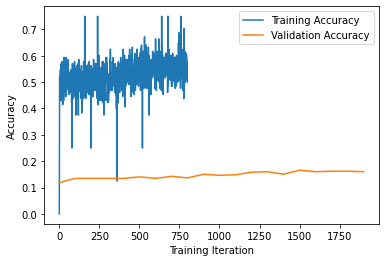

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()